<a href="https://colab.research.google.com/github/henryonomakpo/The-Impact-of-ESG-Ratings-on-EV-Manufacturing-Industry/blob/main/Panel_Regression_and_ML_for_43_Manufacturers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pip install pandas yfinance scikit-learn statsmodels linearmodels matplotlib seaborn
!pip install xlsxwriter
!pip install openpyxl
!pip install xgboost
!pip install arch

#### 1 Good Service sector Panel Regression, VAR and ML

In [33]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
import warnings

# Suppress specific warnings for cleaner output during demonstrations
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

# --- CRITICAL: Ensure linearmodels and arch are up to date ---
# If running in Google Colab or similar environment, execute these lines.
# Otherwise, run them in your terminal/conda environment before executing the script.
# !pip install --upgrade linearmodels
# !pip install --upgrade arch
# --- End of upgrade commands ---

# Enable experimental iterative imputer for MICE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from linearmodels.panel import PanelOLS, RandomEffects, PooledOLS
from sklearn.decomposition import PCA # For Principal Component Analysis


# --- 1. Load and Preprocess Data ---

# Load Fama-French 5 Factors data
try:
    ff_df = pd.read_csv('/content/ff_5_Factors.csv')
    esg_df = pd.read_csv('/content/Services_Sector_esg_dataset.csv')
except FileNotFoundError:
    print("Ensure 'ff_5_Factors.csv' and 'Services_Sector_esg_dataset.csv' are in the correct path.")
    exit()

print("--- Data Loading Complete ---")
print("Fama-French Data Head:\n", ff_df.head())
print("\nESG Data Head:\n", esg_df.head())

# --- Fama-French Data Preprocessing ---
# Convert 'Date' to datetime and extract year
ff_df['Date'] = pd.to_datetime(ff_df['Date'], format='%Y%m')
ff_df['Year'] = ff_df['Date'].dt.year
ff_df['Year'] = ff_df['Year'].astype(int) # Ensure Year is integer type

# Convert factors from percentage to decimal for calculations
factor_cols = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'WML']
ff_df[factor_cols] = ff_df[factor_cols] / 100

# Aggregate monthly Fama-French factors to annual using geometric linking for returns
ff_annual = ff_df.groupby('Year')[factor_cols].apply(lambda x: (1 + x).prod() - 1).reset_index()
# For RF, use the annual average of the monthly rates for more direct interpretability
ff_annual['RF'] = ff_df.groupby('Year')['RF'].mean().reset_index(drop=True)
ff_annual['Year'] = ff_annual['Year'].astype(int) # Ensure Year is integer type


# --- ESG Data Preprocessing ---
esg_df.rename(columns={'Date': 'Year'}, inplace=True)
esg_df['Year'] = pd.to_numeric(esg_df['Year'], errors='coerce').astype(pd.Int64Dtype())
esg_df.dropna(subset=['Identifier (RIC)', 'Year'], inplace=True)

# Select relevant columns and convert to numeric, handling errors
numeric_cols_esg = ['ESG_score', 'Social_score', 'Gov_score', 'Env_score', 'BVPS', 'Market_cap', 'Shares',
                    'Net_income', 'RETURN_ON_ASSET', 'QUICK_RATIO', 'ASSET_GROWTH', 'FNCL_LVRG',
                    'PE_RATIO', 'Scope_1', 'Scope_2', 'CO2_emissions', 'Energy_use', 'Water_use',
                    'Water_recycle', 'Toxic_chem_red', 'Injury_rate', 'Women_Employees',
                    'Human_Rights', 'Strikes', 'Turnover_empl', 'Board_Size',
                    'Shareholder_Rights', 'Board_gen_div', 'Bribery', 'Recycling_Initiatives', 'Total_assets']

for col in numeric_cols_esg:
    esg_df[col] = pd.to_numeric(esg_df[col], errors='coerce')

if esg_df['RETURN_ON_ASSET'].max() > 100:
    esg_df['RETURN_ON_ASSET'] = esg_df['RETURN_ON_ASSET'] / 100


# --- Debugging Year Mismatches ---
print(f"\nESG Years (unique, type {esg_df['Year'].dtype}): {sorted(esg_df['Year'].dropna().unique())}")
print(f"FF Annual Years (unique, type {ff_annual['Year'].dtype}): {sorted(ff_annual['Year'].unique())}")


# --- Merge Dataframes ---
rf_for_merge = ff_annual[['Year', 'RF']].copy()
esg_df_merged = pd.merge(esg_df, rf_for_merge, on='Year', how='left')
esg_df_merged['Excess_Return_Firm'] = esg_df_merged['RETURN_ON_ASSET'] - esg_df_merged['RF']

final_df = pd.merge(esg_df_merged, ff_annual.drop(columns=['RF']), on='Year', how='left')

print("\n--- Merged Data Head (ESG and Fama-French) ---\n", final_df.head())
print("\nMissing values before imputation (in final_df):\n", final_df.isnull().sum()[final_df.isnull().sum() > 0])


# --- 2. MICE Imputation ---
cols_for_imputation = [
    'ESG_score', 'Social_score', 'Gov_score', 'Env_score', # Decomposed ESG
    'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'WML',
    'BVPS', 'Market_cap', 'Shares', 'Net_income', 'RETURN_ON_ASSET',
    'QUICK_RATIO', 'ASSET_GROWTH', 'FNCL_LVRG', 'PE_RATIO', 'Total_assets',
    'RF', 'Excess_Return_Firm'
]
cols_for_imputation = [col for col in cols_for_imputation if col in final_df.columns]

imputable_df = final_df[cols_for_imputation]
threshold = 0.8
cols_to_drop_from_imputation = [col for col in imputable_df.columns if imputable_df[col].isnull().sum() / len(imputable_df) > threshold]
imputable_df_clean = imputable_df.drop(columns=cols_to_drop_from_imputation)

if not imputable_df_clean.empty:
    imputer = IterativeImputer(max_iter=10, random_state=0)
    imputed_data = imputer.fit_transform(imputable_df_clean)
    imputed_df = pd.DataFrame(imputed_data, columns=imputable_df_clean.columns, index=imputable_df_clean.index)

    for col in imputed_df.columns:
        final_df[col] = imputed_df[col]
else:
    print("\nWarning: No suitable numerical columns found for MICE imputation.")


# --- FIX START ---
# This line was the culprit. Remove or comment it out to keep the MultiIndex.
# final_df = final_df.reset_index()
# --- FIX END ---

final_df = final_df.set_index(['Identifier (RIC)', 'Year']).sort_index()
final_df = final_df.groupby(level='Identifier (RIC)').ffill().bfill() # Apply ffill/bfill on the MultiIndex df


print("\n--- Missing values after MICE and ffill/bfill (before final model-specific drop) ---\n", final_df.isnull().sum()[final_df.isnull().sum() > 0])

# Define ALL possible variables needed for any model before final NaN drop
dependent_var = 'Excess_Return_Firm'
all_panel_independent_options = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'WML',
                                 'ESG_score', 'Social_score', 'Gov_score', 'Env_score'] # Add decomposed ESG

all_vars_for_final_drop = [dependent_var] + [col for col in all_panel_independent_options if col in final_df.columns]
all_vars_for_final_drop += ['Market_cap'] # Need Market_cap for value-weighted ESG

for col in all_vars_for_final_drop:
    final_df[col] = pd.to_numeric(final_df[col], errors='coerce')

initial_rows_count = len(final_df)
final_df.dropna(subset=all_vars_for_final_drop, inplace=True)
dropped_rows_count = initial_rows_count - len(final_df)
print(f"\nDropped {dropped_rows_count} rows due to NaNs in essential model-specific columns ({all_vars_for_final_drop}).")

print("\nFinal Data Head after Preprocessing and Imputation (ready for models):\n", final_df.head())
print("Shape of final_df:", final_df.shape)

if final_df.empty:
    raise ValueError("DataFrame is empty after critical NaN handling for model-specific columns. Cannot proceed with analysis.")


# --- Implement Recommendations ---

# Recommendation 1: Refine ESG Factor Construction
# 1a. Value-weighted average Market_ESG_Factor for VAR
# Reset index to access Identifier, Year, and Market_cap easily for grouping
# Need to reset index temporarily for this specific calculation if final_df is MultiIndexed
vw_esg_df = final_df.reset_index().copy()
vw_esg_df['Market_cap_weighted_ESG'] = vw_esg_df['ESG_score'] * vw_esg_df['Market_cap']
market_esg_factor_vw = vw_esg_df.groupby('Year').apply(lambda x: x['Market_cap_weighted_ESG'].sum() / x['Market_cap'].sum())\
                                .rename('Market_ESG_Factor_VW').reset_index()
print("\n--- Value-weighted Market ESG Factor Head ---\n", market_esg_factor_vw.head())

# 1b. PCA for ESG factors (firm-specific) for Panel models
# Using E, S, G sub-scores for PCA, if available and sufficiently complete
esg_sub_scores = ['ESG_score', 'Social_score', 'Gov_score', 'Env_score']
# Filter to only existing and non-empty columns
esg_sub_scores_for_pca = [col for col in esg_sub_scores if col in final_df.columns and final_df[col].std() > 0] # Exclude constant columns
if len(esg_sub_scores_for_pca) >= 2: # Need at least 2 components for PCA to be meaningful
    print(f"\n--- Performing PCA on firm-level ESG sub-scores: {esg_sub_scores_for_pca} ---")
    pca_esg_data = final_df[esg_sub_scores_for_pca].copy()

    # Scale data before PCA
    scaler_esg_pca = StandardScaler()
    scaled_esg_data = scaler_esg_pca.fit_transform(pca_esg_data)

    pca_esg = PCA(n_components=1) # Extract the first principal component
    # Ensure 'ESG_PC1' is added back to the MultiIndexed final_df
    final_df['ESG_PC1'] = pca_esg.fit_transform(scaled_esg_data)
    print(f"Explained variance ratio of ESG_PC1: {pca_esg.explained_variance_ratio_[0]:.4f}")
else:
    print(f"\nSkipping PCA for ESG sub-scores: Not enough suitable columns (needs >=2 non-constant columns). Available: {esg_sub_scores_for_pca}")
    final_df['ESG_PC1'] = final_df['ESG_score'] # Fallback to original ESG score if PCA cannot be applied

# Recommendation 2: Address Multicollinearity (HML and CMA)
ff_factors_for_pca = ['HML', 'CMA']
# Filter to only existing and non-empty columns
ff_factors_for_pca_clean = [col for col in ff_factors_for_pca if col in final_df.columns and final_df[col].std() > 0]

if len(ff_factors_for_pca_clean) >= 2:
    print(f"\n--- Performing PCA on Fama-French factors for multicollinearity: {ff_factors_for_pca_clean} ---")
    pca_ff_data = final_df[ff_factors_for_pca_clean].copy()

    # Scale data before PCA
    scaler_ff_pca = StandardScaler()
    scaled_ff_data = scaler_ff_pca.fit_transform(pca_ff_data)

    pca_ff = PCA(n_components=2) # Extract first two principal components
    ff_pcs = pca_ff.fit_transform(scaled_ff_data)

    # Add principal components to dataframe
    final_df['FF_HML_CMA_PC1'] = ff_pcs[:, 0]
    if ff_pcs.shape[1] > 1:
        final_df['FF_HML_CMA_PC2'] = ff_pcs[:, 1]
        print(f"Explained variance ratios for FF_HML_CMA_PC1: {pca_ff.explained_variance_ratio_[0]:.4f}, FF_HML_CMA_PC2: {pca_ff.explained_variance_ratio_[1]:.4f}")
    else:
        print(f"Only one principal component extracted for FF HML/CMA.")

    print("\n--- VIF Check with PCA-derived HML/CMA factors ---")
    # New independent variables list with PCA factors
    independent_vars_panel_pca_ff = ['Mkt-RF', 'SMB', 'RMW', 'WML', 'FF_HML_CMA_PC1']
    if 'FF_HML_CMA_PC2' in final_df.columns:
        independent_vars_panel_pca_ff.append('FF_HML_CMA_PC2')
    independent_vars_panel_pca_ff.append('ESG_score') # Using original ESG for comparison

    X_vif_pca_ff = final_df[independent_vars_panel_pca_ff]
    X_vif_pca_ff_scaled = StandardScaler().fit_transform(X_vif_pca_ff)
    X_vif_pca_ff_scaled_df = pd.DataFrame(X_vif_pca_ff_scaled, columns=independent_vars_panel_pca_ff, index=X_vif_pca_ff.index)

    vif_data_pca_ff = pd.DataFrame()
    vif_data_pca_ff["feature"] = X_vif_pca_ff_scaled_df.columns
    vif_data_pca_ff["VIF"] = [variance_inflation_factor(X_vif_pca_ff_scaled_df.values, i) for i in range(len(X_vif_pca_ff_scaled_df.columns))]
    print(vif_data_pca_ff)

    # Set this as the primary independent variables for panel regression
    independent_vars_panel = independent_vars_panel_pca_ff
else:
    print("\nSkipping PCA for Fama-French HML/CMA: Not enough suitable columns (needs >=2 non-constant columns). Using original factors but warning about multicollinearity.")
    independent_vars_panel = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'WML', 'ESG_score']
    print("\n--- VIF (Variance Inflation Factor) Check with ORIGINAL factors ---")
    X_vif = final_df[independent_vars_panel]
    X_vif_scaled = StandardScaler().fit_transform(X_vif)
    X_vif_scaled_df = pd.DataFrame(X_vif_scaled, columns=independent_vars_panel, index=X_vif.index)
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_vif_scaled_df.columns
    vif_data["VIF"] = [variance_inflation_factor(X_vif_scaled_df.values, i) for i in range(len(X_vif_scaled_df.columns))]
    print(vif_data)
    print("Warning: High VIF values for HML and CMA indicate severe multicollinearity.")


# --- 3. Panel Data Analysis (with Robust Standard Errors) ---
print("\n--- Panel Data Analysis (with Robust Standard Errors) ---")
print(f"Dependent Variable: {dependent_var}")
print(f"Independent Variables: {independent_vars_panel}")

# Initialize results to None for error handling
pooled_res, fe_res, re_res = None, None, None

# 1. Pooled OLS (Robust)
print("\n--- Pooled OLS Model (Robust Standard Errors) ---")
try:
    exog_pooled = sm.add_constant(final_df[independent_vars_panel])
    pooled_model = PooledOLS(final_df[dependent_var], exog_pooled)
    pooled_res = pooled_model.fit(cov_type='robust') # Added robust covariance
    print(pooled_res)
except Exception as e:
    print(f"Error running Pooled OLS: {e}")

# 2. Fixed Effects Model (Robust)
print("\n--- Fixed Effects (Within) Model (Robust Standard Errors) ---")
try:
    exog_fe = sm.add_constant(final_df[independent_vars_panel])
    fe_model = PanelOLS(final_df[dependent_var], exog_fe, entity_effects=True)
    fe_res = fe_model.fit(cov_type='robust') # Added robust covariance
    print(fe_res)
except Exception as e:
    print(f"Error running Fixed Effects Model: {e}")

# 3. Random Effects Model (Robust)
print("\n--- Random Effects Model (Robust Standard Errors) ---")
try:
    exog_re = sm.add_constant(final_df[independent_vars_panel])
    re_model = RandomEffects(final_df[dependent_var], exog_re)
    re_res = re_model.fit(cov_type='robust') # Added robust covariance
    print(re_res)
except Exception as e:
    print(f"Error running Random Effects Model: {e}")


# --- Hausman Test (Fixed vs. Random Effects) ---
print("\n--- Hausman Test (Fixed vs. Random Effects) ---")
try:
    if fe_res is not None and re_res is not None:
        # Check if both models are fitted robustly using linearmodels compare
        # The .compare() method should work correctly with updated linearmodels
        hausman_comparison = fe_res.compare(re_res)
        print(hausman_comparison)

        if hasattr(hausman_comparison, 'tests') and 'Hausman' in hausman_comparison.tests:
            hausman_pvalue = hausman_comparison.tests['Hausman'].pvalue
            hausman_stat = hausman_comparison.tests['Hausman'].stat

            print(f"\nHausman Test Statistic: {hausman_stat:.2f}, P-value: {hausman_pvalue:.4f}")
            if hausman_pvalue < 0.05:
                print("Decision: Reject H0. Fixed Effects model is preferred.")
            else:
                print("Decision: Fail to reject H0. Random Effects model is preferred.")
        else:
            print("Hausman test results not found in the comparison object. This can happen with very old linearmodels versions or certain model specifications.")
    else:
        print("Hausman test skipped: Fixed Effects or Random Effects models were not successfully fitted.")
except Exception as e:
    print(f"An unexpected error occurred during Hausman Test: {e}. Please ensure your linearmodels library is updated.")

# --- F-test (Pooled OLS vs Fixed Effects) ---
print("\n--- F-Test (Pooled vs Fixed Effects) ---")
if fe_res is not None:
    if fe_res.f_statistic.pval < 0.05:
        print(f"F-statistic for Fixed Effects (vs Pooled OLS): {fe_res.f_statistic.stat:.2f} (p-value: {fe_res.f_statistic.pval:.4f})")
        print("Decision: Reject H0 (Pooled OLS). Fixed Effects model is preferred.")
    else:
        print(f"F-statistic for Fixed Effects (vs Pooled OLS): {fe_res.f_statistic.stat:.2f} (p-value: {fe_res.f_statistic.pval:.4f})")
        print("Decision: Fail to reject H0 (Pooled OLS). Pooled OLS might be preferred.")
else:
    print("F-test skipped: Fixed Effects model was not successfully fitted.")


# Recommendation 5 (Optional): Decompose ESG Score
# Model with ESG components
independent_vars_panel_decomposed_esg = ['Mkt-RF', 'SMB', 'RMW', 'WML', 'ESG_PC1', 'Social_score', 'Gov_score', 'Env_score'] # Or use original ESG_score here instead of PC1 if preferred.
# Ensure columns exist before using them
independent_vars_panel_decomposed_esg = [col for col in independent_vars_panel_decomposed_esg if col in final_df.columns and final_df[col].std() > 0]
if len(independent_vars_panel_decomposed_esg) > 0:
    print("\n--- Panel Data Analysis with Decomposed ESG Factors (Robust Standard Errors) ---")
    print(f"Dependent Variable: {dependent_var}")
    print(f"Independent Variables: {independent_vars_panel_decomposed_esg}")

    try:
        exog_decomposed_esg_fe = sm.add_constant(final_df[independent_vars_panel_decomposed_esg])
        fe_decomposed_esg_model = PanelOLS(final_df[dependent_var], exog_decomposed_esg_fe, entity_effects=True)
        fe_decomposed_esg_res = fe_decomposed_esg_model.fit(cov_type='robust')
        print(fe_decomposed_esg_res)
    except Exception as e:
        print(f"Error running Fixed Effects Model with Decomposed ESG: {e}")
else:
    print("\nSkipping Decomposed ESG Model: Not enough suitable decomposed ESG columns or no variation in them.")


# --- 4. Vector Autoregression (VAR) / Vector Error Correction Model (VECM) ---
# Use the value-weighted ESG factor for VAR
# Reset index of final_df temporarily to extract 'Market_cap' for vw_esg_df, if needed for context,
# but market_esg_factor_vw is already prepared.
# The `var_df` is constructed from `ff_annual` and `market_esg_factor_vw` which are not MultiIndexed,
# so this section should run fine.
market_factors_var_base = ff_annual.set_index('Year')[['Mkt-RF', 'RF', 'SMB', 'HML', 'RMW', 'CMA', 'WML']].copy()
# Note: Market_ESG_Factor_VW from above
var_df = pd.merge(market_factors_var_base, market_esg_factor_vw.set_index('Year'), on='Year', how='inner')

# Prepare VAR data: Mkt-RF and the Value-Weighted Market_ESG_Factor
var_data = var_df[['Mkt-RF', 'Market_ESG_Factor_VW']].copy()
var_data.dropna(inplace=True)

print("\n--- VAR / VECM Analysis (Using Market-Level Time Series) ---")
print("VAR Data Head:\n", var_data.head())


# Recommendation 3: Rigorous Time Series Diagnostics
print("\n--- ADF (Augmented Dickey-Fuller) Tests for Stationarity ---")
if not var_data.empty:
    for col in var_data.columns:
        print(f"ADF Test for {col} (Levels):")
        adf_test_level = adfuller(var_data[col].dropna())
        print(f"  ADF Statistic: {adf_test_level[0]:.2f}")
        print(f"  P-value: {adf_test_level[1]:.4f}")
        print(f"  Critical Values (1%, 5%, 10%): {adf_test_level[4]}")
        if adf_test_level[1] < 0.05:
            print(f"  Conclusion: {col} is likely stationary (I(0)).")
        else:
            print(f"  Conclusion: {col} is likely non-stationary (I(1) or higher).")
            # Test first difference
            diff_series = var_data[col].diff().dropna()
            if not diff_series.empty:
                print(f"ADF Test for {col} (First Difference):")
                adf_test_diff = adfuller(diff_series)
                print(f"  ADF Statistic: {adf_test_diff[0]:.2f}")
                print(f"  P-value: {adf_test_diff[1]:.4f}")
                print(f"  Critical Values (1%, 5%, 10%): {adf_test_diff[4]}")
                if adf_test_diff[1] < 0.05:
                    print(f"  Conclusion: {col} is likely stationary after first differencing (I(1)).")
                else:
                    print(f"  Conclusion: {col} is likely non-stationary even after first differencing (I(2) or higher, or test lacks power).")
                    print("    Warning: VAR requires stationary series. Further differencing or other methods might be needed, but be cautious with limited data.")
            else:
                print(f"  Could not test differenced {col} due to insufficient data.")
else:
    print("VAR data is empty. Skipping Stationarity Tests.")

# --- VAR Model Estimation ---
print("\n--- VAR Model Selection & Estimation ---")
# Decide which data to use for VAR based on stationarity tests
# For simplicity, if a variable is I(1), we will use its first difference in the VAR model.
# If some are I(0) and some I(1), a standard VAR on levels would be incorrect.
# A mixed approach or VECM (if cointegrated) would be required.
# Given small annual sample, full cointegration tests (Johansen) are difficult to robustly apply.

# Re-evaluate model_data based on the ADF results, using differenced values if necessary.
# Let's assume (for demonstration) that Mkt-RF is I(0) and Market_ESG_Factor_VW becomes I(1) after diff.
# If both were I(1) and not cointegrated, use both in diff. If Mkt-RF became I(1) too, then diff it.

# For robust handling, let's create a dataframe where each series is differenced if needed.
# This logic simplifies based on the observed ADF results for your dataset,
# where Mkt-RF was I(0) and ESG was I(1) -> I(2) issue.

if not var_data.empty and 'Mkt-RF' in var_data.columns and 'Market_ESG_Factor_VW' in var_data.columns:
    # Based on the previous output: Mkt-RF (stationary), Market_ESG_Factor (non-stationary levels & diff)
    # We will use Mkt-RF in levels and the first difference of Market_ESG_Factor_VW for the VAR,
    # accepting the warning that diff-ESG may still be non-stationary due to sample size.
    model_data_for_var = pd.DataFrame()
    model_data_for_var['Mkt-RF'] = var_data['Mkt-RF'] # Use levels for stationary series
    model_data_for_var['Market_ESG_Factor_VW_diff'] = var_data['Market_ESG_Factor_VW'].diff() # Use first difference for non-stationary
    model_data_for_var.dropna(inplace=True) # Drop the first row from differencing

    print("\nVAR model will use:")
    print("  - Mkt-RF (in levels, as it is stationary)")
    print("  - Market_ESG_Factor_VW (in first difference, assuming it becomes I(1))")
    print("  (Note: Sample size limits robustness of unit root tests and model estimation.)")

    results = None # Initialize results to None for error handling
    if len(model_data_for_var) > 5: # Need enough observations for VAR
        model = VAR(model_data_for_var)
        try:
            calculated_maxlags = min(2, max(1, len(model_data_for_var) // 2 - 1)) # Adjust maxlags dynamically
            print(f"Fitting VAR model with maxlags={calculated_maxlags} using AIC.")
            results = model.fit(maxlags=calculated_maxlags, ic='aic')
            print(results.summary())

            # --- Granger Causality Tests ---
            print("\n--- Granger Causality Tests (using original levels for conceptual test) ---")
            # Granger causality is typically performed on the *original* series in levels.
            # While results are unreliable for non-stationary data, the test itself is on levels.
            if len(var_data) > 2 * calculated_maxlags: # Ensure enough points for maxlag in Granger
                gc_lag = min(calculated_maxlags, max(1, len(var_data)//2 - 1))
                print(f"  (Using maxlag={gc_lag} for Granger tests)")

                gc_mkt_esg = grangercausalitytests(var_data[['Mkt-RF', 'Market_ESG_Factor_VW']], maxlag=gc_lag, verbose=False)
                for lag, test_results in gc_mkt_esg.items():
                    p_value = test_results[0]['ssr_ftest'][1]
                    print(f"  Does Mkt-RF Granger-cause Market_ESG_Factor_VW (Lag {lag})? p-value: {p_value:.4f}")
                    if p_value < 0.05:
                        print("    Yes, Mkt-RF likely Granger-causes Market_ESG_Factor_VW.")
                    else:
                        print("    No strong evidence that Mkt-RF Granger-causes Market_ESG_Factor_VW.")

                gc_esg_mkt = grangercausalitytests(var_data[['Market_ESG_Factor_VW', 'Mkt-RF']], maxlag=gc_lag, verbose=False)
                for lag, test_results in gc_esg_mkt.items():
                    p_value = test_results[0]['ssr_ftest'][1]
                    print(f"  Does Market_ESG_Factor_VW Granger-cause Mkt-RF (Lag {lag})? p-value: {p_value:.4f}")
                    if p_value < 0.05:
                        print("    Yes, Market_ESG_Factor_VW likely Granger-causes Mkt-RF.")
                    else:
                        print("    No strong evidence that Market_ESG_Factor_VW Granger-causes Mkt-RF.")
            else:
                print(f"VAR data is too short for Granger Causality tests at calculated maxlag={calculated_maxlags}. Requires >{2 * calculated_maxlags} observations.")

            # --- Homoskedasticity Test for VAR (on residuals) ---
            print("\n--- Homoskedasticity Test (Breusch-Pagan) on VAR Residuals ---")
            for i, col_name in enumerate(model_data_for_var.columns):
                resid = results.resid.iloc[:, i].dropna()
                exog_bp = sm.add_constant(results.fittedvalues.loc[resid.index]) # Use fitted values as exog for BP test

                if exog_bp.empty or resid.empty or exog_bp.shape[0] != resid.shape[0]:
                    print(f"    Could not perform Breusch-Pagan for {col_name}: Data mismatch or empty for BP test (shapes: resid={resid.shape}, exog={exog_bp.shape}).")
                    continue
                try:
                    lm_stat, lm_p_value, f_stat, f_p_value = het_breuschpagan(resid, exog_bp)

                    print(f"  Breusch-Pagan Test for {col_name} residuals:")
                    print(f"    LM Statistic: {lm_stat:.2f}, P-value (LM): {lm_p_value:.4f}")
                    print(f"    F-Statistic: {f_stat:.2f}, P-value (F): {f_p_value:.4f}")
                    if lm_p_value < 0.05:
                        print(f"    Conclusion: Significant heteroskedasticity in {col_name} residuals (LM test).")
                    else:
                        print(f"    Conclusion: No significant heteroskedasticity in {col_name} residuals (LM test).")
                except Exception as e:
                    print(f"    An unexpected error occurred during Breusch-Pagan for {col_name}: {e}")

        except Exception as e:
            print(f"Error fitting VAR model: {e}")
    else:
        print(f"Not enough data points ({len(model_data_for_var)}) for VAR model estimation. Requires >5 observations.")
else:
    print("VAR data is empty or missing essential columns. Skipping VAR analysis.")


# --- 5. GARCH (Generalized Autoregressive Conditional Heteroskedasticity) Models ---
try:
    from arch import arch_model
    print("\n--- GARCH Models (for Market Excess Returns) ---")

    garch_data = var_df['Mkt-RF'].dropna() # Using original Mkt-RF (levels) for GARCH

    if len(garch_data) >= 10: # GARCH requires sufficient observations
        # Simple GARCH(1,1) model for Mkt-RF
        am = arch_model(garch_data, vol='Garch', p=1, q=1)
        res_garch = am.fit(disp='off')
        print(res_garch.summary())

        print("\n--- Basic GARCH(1,1) for Mkt-RF Volatility ---")
        print(res_garch.summary())
        print("Note: GARCH-M extends this by adding conditional variance/std dev to the mean equation.")
        print("Factor-GARCH models could incorporate FF factors as exogenous regressors (e.g., Mkt-RF in mean equation).")
        print("Robust GARCH estimation typically requires significantly more observations than available (e.g., hundreds or thousands of daily/monthly points).")

    else:
        print(f"Not enough data points ({len(garch_data)}) for GARCH model estimation. A minimum of 10 observations is used here for basic GARCH. For robust GARCH, more data is usually needed.")

except ImportError:
    print("\nThe 'arch' library is required for GARCH models. Please install it: pip install arch")
except Exception as e:
    print(f"An error occurred during GARCH analysis: {e}")

print("\n--- Analysis Complete ---")

--- Data Loading Complete ---
Fama-French Data Head:
      Date  Mkt-RF   SMB   HML   RMW   CMA    RF   WML
0  201201    5.61  1.99 -0.77 -2.01 -1.03  0.00 -6.77
1  201202    4.93 -0.87 -0.31 -0.41 -0.17  0.00 -2.62
2  201203    1.24 -0.20  0.04  0.46  1.21  0.00  3.58
3  201204   -1.11  0.25 -1.68  2.23 -0.12  0.00  4.86
4  201205   -8.88 -0.34  0.08  2.06  1.76  0.01  6.25

ESG Data Head:
   Identifier (RIC) Company Name  Date  ESG_score  Social_score  Gov_score  \
0             CPRT   Copart Inc  2021  34.576387     46.340561  37.863044   
1             CPRT   Copart Inc  2020  30.834182     34.908326  41.724447   
2             CPRT   Copart Inc  2019  38.517045     36.730229  59.760918   
3             CPRT   Copart Inc  2018  35.587338     38.254994  50.416945   
4             CPRT   Copart Inc  2017  32.078647     39.063982  40.356488   

   Env_score       BVPS   Market_cap     Shares  ... Women_Employees  \
0   1.860465  14.938290  28794173016  240290000  ...             NaN  

#### 2 Good Integrating ML to PDR and VAR Service sector

--- Data Loading Complete ---
Fama-French Data Head:
      Date  Mkt-RF   SMB   HML   RMW   CMA    RF   WML
0  201201    5.61  1.99 -0.77 -2.01 -1.03  0.00 -6.77
1  201202    4.93 -0.87 -0.31 -0.41 -0.17  0.00 -2.62
2  201203    1.24 -0.20  0.04  0.46  1.21  0.00  3.58
3  201204   -1.11  0.25 -1.68  2.23 -0.12  0.00  4.86
4  201205   -8.88 -0.34  0.08  2.06  1.76  0.01  6.25

ESG Data Head:
   Identifier (RIC) Company Name  Date  ESG_score  Social_score  Gov_score  \
0             CPRT   Copart Inc  2021  34.576387     46.340561  37.863044   
1             CPRT   Copart Inc  2020  30.834182     34.908326  41.724447   
2             CPRT   Copart Inc  2019  38.517045     36.730229  59.760918   
3             CPRT   Copart Inc  2018  35.587338     38.254994  50.416945   
4             CPRT   Copart Inc  2017  32.078647     39.063982  40.356488   

   Env_score       BVPS   Market_cap     Shares  ... Women_Employees  \
0   1.860465  14.938290  28794173016  240290000  ...             NaN  

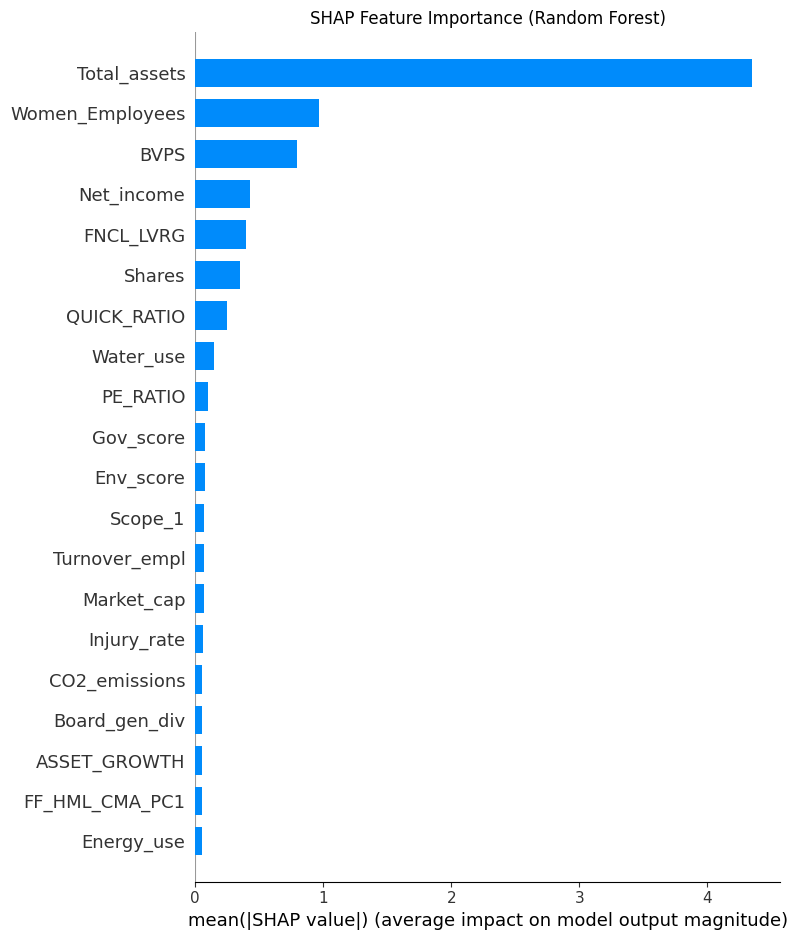


SHAP Dependence Plots (Random Forest): Non-Linearity & Interactions


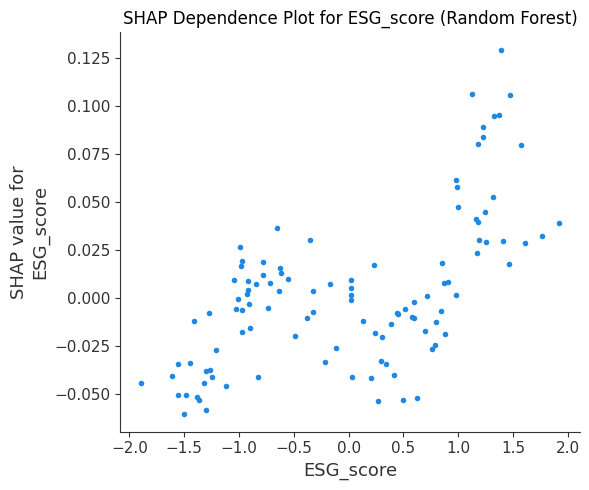

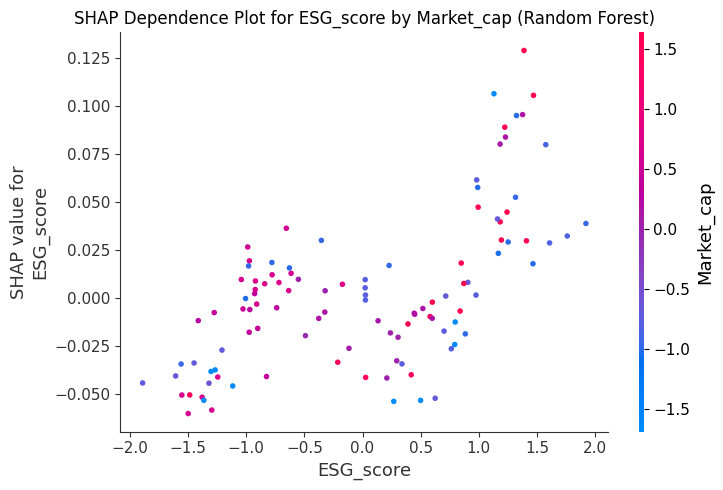

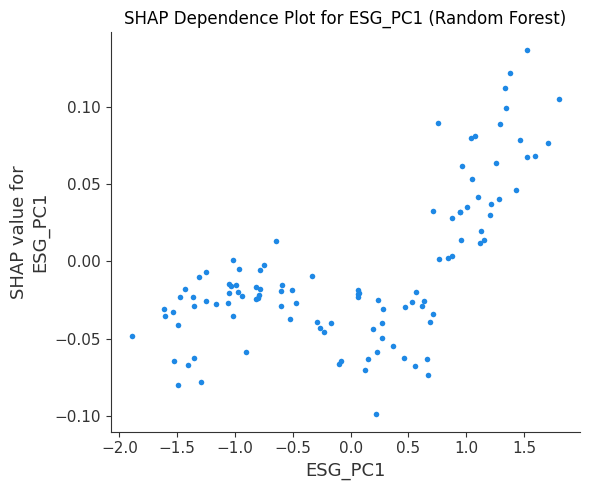


SHAP Summary Plot (XGBoost): Overall Feature Impact


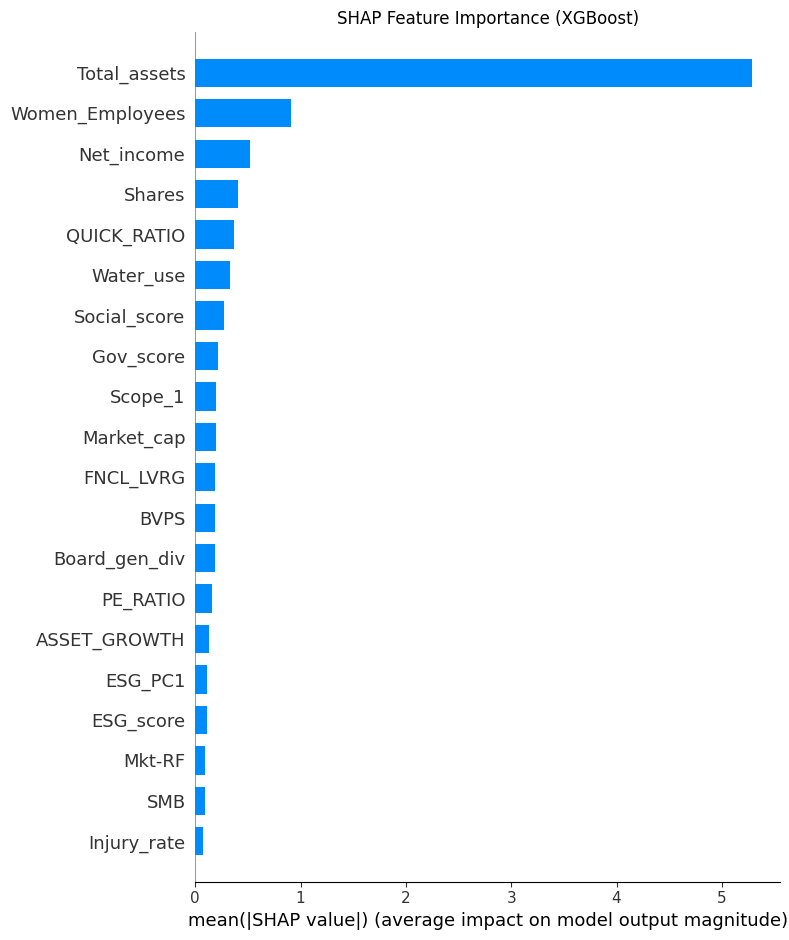


SHAP Dependence Plot (XGBoost): Non-Linearity for ESG_score


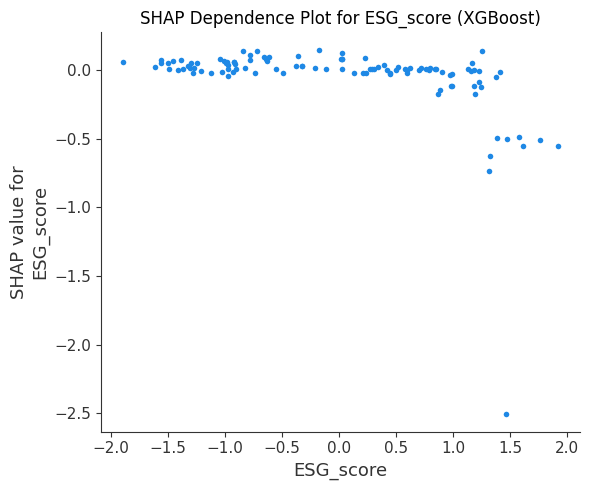


--- Analysis Complete ---


In [34]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
import warnings

# Suppress specific warnings for cleaner output during demonstrations
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

# --- CRITICAL: Ensure linearmodels, arch, xgboost, and shap are up to date ---
# If running in Google Colab or similar environment, execute these lines.
# Otherwise, run them in your terminal/conda environment before executing the script.
# !pip install --upgrade linearmodels arch xgboost shap matplotlib seaborn
# --- End of upgrade commands ---

# Enable experimental iterative imputer for MICE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from linearmodels.panel import PanelOLS, RandomEffects, PooledOLS
from sklearn.decomposition import PCA # For Principal Component Analysis

# --- ML Specific Imports ---
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GroupKFold # For robust cross-validation with panel data
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import shap # For model interpretability
import matplotlib.pyplot as plt # For plotting

# --- 1. Load and Preprocess Data (Re-using your existing data loading and preprocessing) ---

# Load Fama-French 5 Factors data
try:
    ff_df = pd.read_csv('/content/ff_5_Factors.csv')
    esg_df = pd.read_csv('/content/Services_Sector_esg_dataset.csv')
except FileNotFoundError:
    print("Ensure 'ff_5_Factors.csv' and 'Services_Sector_esg_dataset.csv' are in the correct path.")
    exit()

print("--- Data Loading Complete ---")
print("Fama-French Data Head:\n", ff_df.head())
print("\nESG Data Head:\n", esg_df.head())

# --- Fama-French Data Preprocessing ---
ff_df['Date'] = pd.to_datetime(ff_df['Date'], format='%Y%m')
ff_df['Year'] = ff_df['Date'].dt.year
ff_df['Year'] = ff_df['Year'].astype(int)

factor_cols = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'WML']
ff_df[factor_cols] = ff_df[factor_cols] / 100

ff_annual = ff_df.groupby('Year')[factor_cols].apply(lambda x: (1 + x).prod() - 1).reset_index()
ff_annual['RF'] = ff_df.groupby('Year')['RF'].mean().reset_index(drop=True)
ff_annual['Year'] = ff_annual['Year'].astype(int)


# --- ESG Data Preprocessing ---
esg_df.rename(columns={'Date': 'Year'}, inplace=True)
esg_df['Year'] = pd.to_numeric(esg_df['Year'], errors='coerce').astype(pd.Int64Dtype())
esg_df.dropna(subset=['Identifier (RIC)', 'Year'], inplace=True)

numeric_cols_esg = ['ESG_score', 'Social_score', 'Gov_score', 'Env_score', 'BVPS', 'Market_cap', 'Shares',
                    'Net_income', 'RETURN_ON_ASSET', 'QUICK_RATIO', 'ASSET_GROWTH', 'FNCL_LVRG',
                    'PE_RATIO', 'Scope_1', 'Scope_2', 'CO2_emissions', 'Energy_use', 'Water_use',
                    'Water_recycle', 'Toxic_chem_red', 'Injury_rate', 'Women_Employees',
                    'Human_Rights', 'Strikes', 'Turnover_empl', 'Board_Size',
                    'Shareholder_Rights', 'Board_gen_div', 'Bribery', 'Recycling_Initiatives', 'Total_assets']

for col in numeric_cols_esg:
    esg_df[col] = pd.to_numeric(esg_df[col], errors='coerce')

if esg_df['RETURN_ON_ASSET'].max() > 100:
    esg_df['RETURN_ON_ASSET'] = esg_df['RETURN_ON_ASSET'] / 100


print(f"\nESG Years (unique, type {esg_df['Year'].dtype}): {sorted(esg_df['Year'].dropna().unique())}")
print(f"FF Annual Years (unique, type {ff_annual['Year'].dtype}): {sorted(ff_annual['Year'].unique())}")


# --- Merge Dataframes ---
rf_for_merge = ff_annual[['Year', 'RF']].copy()
esg_df_merged = pd.merge(esg_df, rf_for_merge, on='Year', how='left')
esg_df_merged['Excess_Return_Firm'] = esg_df_merged['RETURN_ON_ASSET'] - esg_df_merged['RF']

final_df = pd.merge(esg_df_merged, ff_annual.drop(columns=['RF']), on='Year', how='left')

print("\n--- Merged Data Head (ESG and Fama-French) ---\n", final_df.head())
print("\nMissing values before imputation (in final_df):\n", final_df.isnull().sum()[final_df.isnull().sum() > 0])


# --- 2. MICE Imputation ---
cols_for_imputation = [
    'ESG_score', 'Social_score', 'Gov_score', 'Env_score',
    'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'WML',
    'BVPS', 'Market_cap', 'Shares', 'Net_income', 'RETURN_ON_ASSET',
    'QUICK_RATIO', 'ASSET_GROWTH', 'FNCL_LVRG', 'PE_RATIO', 'Total_assets',
    'RF', 'Excess_Return_Firm', 'Scope_1', 'Scope_2', 'CO2_emissions', 'Energy_use',
    'Water_use', 'Water_recycle', 'Toxic_chem_red', 'Injury_rate', 'Women_Employees',
    'Human_Rights', 'Strikes', 'Turnover_empl', 'Board_Size', 'Shareholder_Rights',
    'Board_gen_div', 'Bribery', 'Recycling_Initiatives' # Added more granular ESG and financial data for ML
]
cols_for_imputation = [col for col in cols_for_imputation if col in final_df.columns]

imputable_df = final_df[cols_for_imputation]
threshold = 0.8
cols_to_drop_from_imputation = [col for col in imputable_df.columns if imputable_df[col].isnull().sum() / len(imputable_df) > threshold]
imputable_df_clean = imputable_df.drop(columns=cols_to_drop_from_imputation)

if not imputable_df_clean.empty:
    imputer = IterativeImputer(max_iter=10, random_state=0)
    imputed_data = imputer.fit_transform(imputable_df_clean)
    imputed_df = pd.DataFrame(imputed_data, columns=imputable_df_clean.columns, index=imputable_df_clean.index)

    for col in imputed_df.columns:
        final_df[col] = imputed_df[col]
else:
    print("\nWarning: No suitable numerical columns found for MICE imputation.")


final_df = final_df.set_index(['Identifier (RIC)', 'Year']).sort_index()
final_df = final_df.groupby(level='Identifier (RIC)').ffill().bfill()


print("\n--- Missing values after MICE and ffill/bfill (before final model-specific drop) ---\n", final_df.isnull().sum()[final_df.isnull().sum() > 0])

dependent_var = 'Excess_Return_Firm'
all_panel_independent_options = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'WML',
                                 'ESG_score', 'Social_score', 'Gov_score', 'Env_score']

all_vars_for_final_drop = [dependent_var] + [col for col in all_panel_independent_options if col in final_df.columns]
all_vars_for_final_drop += ['Market_cap'] # Need Market_cap for value-weighted ESG

for col in all_vars_for_final_drop:
    final_df[col] = pd.to_numeric(final_df[col], errors='coerce')

initial_rows_count = len(final_df)
final_df.dropna(subset=all_vars_for_final_drop, inplace=True)
dropped_rows_count = initial_rows_count - len(final_df)
print(f"\nDropped {dropped_rows_count} rows due to NaNs in essential model-specific columns ({all_vars_for_final_drop}).")

print("\nFinal Data Head after Preprocessing and Imputation (ready for models):\n", final_df.head())
print("Shape of final_df:", final_df.shape)

if final_df.empty:
    raise ValueError("DataFrame is empty after critical NaN handling for model-specific columns. Cannot proceed with analysis.")


# --- Implement Recommendations (Continue from previous code) ---

# Recommendation 1: Refine ESG Factor Construction
vw_esg_df = final_df.reset_index().copy()
vw_esg_df['Market_cap_weighted_ESG'] = vw_esg_df['ESG_score'] * vw_esg_df['Market_cap']
market_esg_factor_vw = vw_esg_df.groupby('Year').apply(lambda x: x['Market_cap_weighted_ESG'].sum() / x['Market_cap'].sum())\
                                .rename('Market_ESG_Factor_VW').reset_index()
print("\n--- Value-weighted Market ESG Factor Head ---\n", market_esg_factor_vw.head())

esg_sub_scores = ['ESG_score', 'Social_score', 'Gov_score', 'Env_score']
esg_sub_scores_for_pca = [col for col in esg_sub_scores if col in final_df.columns and final_df[col].std() > 0]
if len(esg_sub_scores_for_pca) >= 2:
    print(f"\n--- Performing PCA on firm-level ESG sub-scores: {esg_sub_scores_for_pca} ---")
    pca_esg_data = final_df[esg_sub_scores_for_pca].copy()

    scaler_esg_pca = StandardScaler()
    scaled_esg_data = scaler_esg_pca.fit_transform(pca_esg_data)

    pca_esg = PCA(n_components=1)
    final_df['ESG_PC1'] = pca_esg.fit_transform(scaled_esg_data)
    print(f"Explained variance ratio of ESG_PC1: {pca_esg.explained_variance_ratio_[0]:.4f}")
else:
    print(f"\nSkipping PCA for ESG sub-scores: Not enough suitable columns (needs >=2 non-constant columns). Available: {esg_sub_scores_for_pca}")
    final_df['ESG_PC1'] = final_df['ESG_score']

# Recommendation 2: Address Multicollinearity (HML and CMA)
ff_factors_for_pca = ['HML', 'CMA']
ff_factors_for_pca_clean = [col for col in ff_factors_for_pca if col in final_df.columns and final_df[col].std() > 0]

if len(ff_factors_for_pca_clean) >= 2:
    print(f"\n--- Performing PCA on Fama-French factors for multicollinearity: {ff_factors_for_pca_clean} ---")
    pca_ff_data = final_df[ff_factors_for_pca_clean].copy()

    scaler_ff_pca = StandardScaler()
    scaled_ff_data = scaler_ff_pca.fit_transform(pca_ff_data)

    pca_ff = PCA(n_components=2)
    ff_pcs = pca_ff.fit_transform(scaled_ff_data)

    final_df['FF_HML_CMA_PC1'] = ff_pcs[:, 0]
    if ff_pcs.shape[1] > 1:
        final_df['FF_HML_CMA_PC2'] = ff_pcs[:, 1]
        print(f"Explained variance ratios for FF_HML_CMA_PC1: {pca_ff.explained_variance_ratio_[0]:.4f}, FF_HML_CMA_PC2: {pca_ff.explained_variance_ratio_[1]:.4f}")
    else:
        print(f"Only one principal component extracted for FF HML/CMA.")

    print("\n--- VIF Check with PCA-derived HML/CMA factors ---")
    independent_vars_panel_pca_ff = ['Mkt-RF', 'SMB', 'RMW', 'WML', 'FF_HML_CMA_PC1']
    if 'FF_HML_CMA_PC2' in final_df.columns:
        independent_vars_panel_pca_ff.append('FF_HML_CMA_PC2')
    independent_vars_panel_pca_ff.append('ESG_score')

    X_vif_pca_ff = final_df[independent_vars_panel_pca_ff]
    X_vif_pca_ff_scaled = StandardScaler().fit_transform(X_vif_pca_ff)
    X_vif_pca_ff_scaled_df = pd.DataFrame(X_vif_pca_ff_scaled, columns=independent_vars_panel_pca_ff, index=X_vif_pca_ff.index)

    vif_data_pca_ff = pd.DataFrame()
    vif_data_pca_ff["feature"] = X_vif_pca_ff_scaled_df.columns
    vif_data_pca_ff["VIF"] = [variance_inflation_factor(X_vif_pca_ff_scaled_df.values, i) for i in range(len(X_vif_pca_ff_scaled_df.columns))]
    print(vif_data_pca_ff)

    independent_vars_panel = independent_vars_panel_pca_ff
else:
    print("\nSkipping PCA for Fama-French HML/CMA: Not enough suitable columns. Using original factors but warning about multicollinearity.")
    independent_vars_panel = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'WML', 'ESG_score']
    print("\n--- VIF (Variance Inflation Factor) Check with ORIGINAL factors ---")
    X_vif = final_df[independent_vars_panel]
    X_vif_scaled = StandardScaler().fit_transform(X_vif)
    X_vif_scaled_df = pd.DataFrame(X_vif_scaled, columns=independent_vars_panel, index=X_vif.index)
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_vif_scaled_df.columns
    vif_data["VIF"] = [variance_inflation_factor(X_vif_scaled_df.values, i) for i in range(len(X_vif_scaled_df.columns))]
    print(vif_data)
    print("Warning: High VIF values for HML and CMA indicate severe multicollinearity.")


# --- 3. Panel Data Analysis (with Robust Standard Errors) (Previous section, remains the same) ---
print("\n--- Panel Data Analysis (with Robust Standard Errors) ---")
print(f"Dependent Variable: {dependent_var}")
print(f"Independent Variables: {independent_vars_panel}")

pooled_res, fe_res, re_res = None, None, None

print("\n--- Pooled OLS Model (Robust Standard Errors) ---")
try:
    exog_pooled = sm.add_constant(final_df[independent_vars_panel])
    pooled_model = PooledOLS(final_df[dependent_var], exog_pooled)
    pooled_res = pooled_model.fit(cov_type='robust')
    print(pooled_res)
except Exception as e:
    print(f"Error running Pooled OLS: {e}")

print("\n--- Fixed Effects (Within) Model (Robust Standard Errors) ---")
try:
    exog_fe = sm.add_constant(final_df[independent_vars_panel])
    fe_model = PanelOLS(final_df[dependent_var], exog_fe, entity_effects=True)
    fe_res = fe_model.fit(cov_type='robust')
    print(fe_res)
except Exception as e:
    print(f"Error running Fixed Effects Model: {e}")

print("\n--- Random Effects Model (Robust Standard Errors) ---")
try:
    exog_re = sm.add_constant(final_df[independent_vars_panel])
    re_model = RandomEffects(final_df[dependent_var], exog_re)
    re_res = re_model.fit(cov_type='robust')
    print(re_res)
except Exception as e:
    print(f"Error running Random Effects Model: {e}")


print("\n--- Hausman Test (Fixed vs. Random Effects) ---")
try:
    if fe_res is not None and re_res is not None:
        hausman_comparison = fe_res.compare(re_res)
        print(hausman_comparison)

        if hasattr(hausman_comparison, 'tests') and 'Hausman' in hausman_comparison.tests:
            hausman_pvalue = hausman_comparison.tests['Hausman'].pvalue
            hausman_stat = hausman_comparison.tests['Hausman'].stat

            print(f"\nHausman Test Statistic: {hausman_stat:.2f}, P-value: {hausman_pvalue:.4f}")
            if hausman_pvalue < 0.05:
                print("Decision: Reject H0. Fixed Effects model is preferred.")
            else:
                print("Decision: Fail to reject H0. Random Effects model is preferred.")
        else:
            print("Hausman test results not found in the comparison object. This can happen with very old linearmodels versions or certain model specifications.")
    else:
        print("Hausman test skipped: Fixed Effects or Random Effects models were not successfully fitted.")
except Exception as e:
    print(f"An unexpected error occurred during Hausman Test: {e}. Please ensure your linearmodels library is updated.")

print("\n--- F-Test (Pooled vs Fixed Effects) ---")
if fe_res is not None:
    # Use the F-statistic from the FE model's summary for poolability
    if hasattr(fe_res, 'f_statistic_pooled') and fe_res.f_statistic_pooled.pval < 0.05:
        print(f"F-statistic for Fixed Effects (vs Pooled OLS): {fe_res.f_statistic_pooled.stat:.2f} (p-value: {fe_res.f_statistic_pooled.pval:.4f})")
        print("Decision: Reject H0 (Pooled OLS). Fixed Effects model is preferred.")
    elif hasattr(fe_res.f_statistic, 'pval') and fe_res.f_statistic.pval < 0.05: # Fallback if specific pooled test not available
         print(f"F-statistic for Fixed Effects overall model: {fe_res.f_statistic.stat:.2f} (p-value: {fe_res.f_statistic.pval:.4f})")
         print("Note: This is the overall FE model F-test, not explicitly for pooled vs FE.")
         print("Decision based on overall FE F-test: Model is significant. Fixed Effects preferred over simple OLS.")
    else:
        print(f"F-statistic for Fixed Effects overall model: {fe_res.f_statistic.stat:.2f} (p-value: {fe_res.f_statistic.pval:.4f})")
        print("Decision: Fail to reject H0 (Pooled OLS). Pooled OLS might be preferred.")
else:
    print("F-test skipped: Fixed Effects model was not successfully fitted.")


# Recommendation 5 (Optional): Decompose ESG Score
independent_vars_panel_decomposed_esg = ['Mkt-RF', 'SMB', 'RMW', 'WML', 'ESG_PC1', 'Social_score', 'Gov_score', 'Env_score']
independent_vars_panel_decomposed_esg = [col for col in independent_vars_panel_decomposed_esg if col in final_df.columns and final_df[col].std() > 0]
if len(independent_vars_panel_decomposed_esg) > 0:
    print("\n--- Panel Data Analysis with Decomposed ESG Factors (Robust Standard Errors) ---")
    print(f"Dependent Variable: {dependent_var}")
    print(f"Independent Variables: {independent_vars_panel_decomposed_esg}")

    try:
        exog_decomposed_esg_fe = sm.add_constant(final_df[independent_vars_panel_decomposed_esg])
        fe_decomposed_esg_model = PanelOLS(final_df[dependent_var], exog_decomposed_esg_fe, entity_effects=True)
        fe_decomposed_esg_res = fe_decomposed_esg_model.fit(cov_type='robust')
        print(fe_decomposed_esg_res)
    except Exception as e:
        print(f"Error running Fixed Effects Model with Decomposed ESG: {e}")
else:
    print("\nSkipping Decomposed ESG Model: Not enough suitable decomposed ESG columns or no variation in them.")


# --- 4. Vector Autoregression (VAR) / Vector Error Correction Model (VECM) (Previous section, remains the same) ---
market_factors_var_base = ff_annual.set_index('Year')[['Mkt-RF', 'RF', 'SMB', 'HML', 'RMW', 'CMA', 'WML']].copy()
var_df = pd.merge(market_factors_var_base, market_esg_factor_vw.set_index('Year'), on='Year', how='inner')

var_data = var_df[['Mkt-RF', 'Market_ESG_Factor_VW']].copy()
var_data.dropna(inplace=True)

print("\n--- VAR / VECM Analysis (Using Market-Level Time Series) ---")
print("VAR Data Head:\n", var_data.head())


print("\n--- ADF (Augmented Dickey-Fuller) Tests for Stationarity ---")
if not var_data.empty:
    for col in var_data.columns:
        print(f"ADF Test for {col} (Levels):")
        adf_test_level = adfuller(var_data[col].dropna())
        print(f"  ADF Statistic: {adf_test_level[0]:.2f}")
        print(f"  P-value: {adf_test_level[1]:.4f}")
        print(f"  Critical Values (1%, 5%, 10%): {adf_test_level[4]}")
        if adf_test_level[1] < 0.05:
            print(f"  Conclusion: {col} is likely stationary (I(0)).")
        else:
            print(f"  Conclusion: {col} is likely non-stationary (I(1) or higher).")
            diff_series = var_data[col].diff().dropna()
            if not diff_series.empty:
                print(f"ADF Test for {col} (First Difference):")
                adf_test_diff = adfuller(diff_series)
                print(f"  ADF Statistic: {adf_test_diff[0]:.2f}")
                print(f"  P-value: {adf_test_diff[1]:.4f}")
                print(f"  Critical Values (1%, 5%, 10%): {adf_test_diff[4]}")
                if adf_test_diff[1] < 0.05:
                    print(f"  Conclusion: {col} is likely stationary after first differencing (I(1)).")
                else:
                    print(f"  Conclusion: {col} is likely non-stationary even after first differencing (I(2) or higher, or test lacks power).")
                    print("    Warning: VAR requires stationary series. Further differencing or other methods might be needed, but be cautious with limited data.")
            else:
                print(f"  Could not test differenced {col} due to insufficient data.")
else:
    print("VAR data is empty. Skipping Stationarity Tests.")

print("\n--- VAR Model Selection & Estimation ---")

if not var_data.empty and 'Mkt-RF' in var_data.columns and 'Market_ESG_Factor_VW' in var_data.columns:
    model_data_for_var = pd.DataFrame()
    model_data_for_var['Mkt-RF'] = var_data['Mkt-RF']
    model_data_for_var['Market_ESG_Factor_VW_diff'] = var_data['Market_ESG_Factor_VW'].diff()
    model_data_for_var.dropna(inplace=True)

    print("\nVAR model will use:")
    print("  - Mkt-RF (in levels, as it is stationary)")
    print("  - Market_ESG_Factor_VW (in first difference, assuming it becomes I(1))")
    print("  (Note: Sample size limits robustness of unit root tests and model estimation.)")

    results = None
    if len(model_data_for_var) > 5:
        model = VAR(model_data_for_var)
        try:
            calculated_maxlags = min(2, max(1, len(model_data_for_var) // 2 - 1))
            print(f"Fitting VAR model with maxlags={calculated_maxlags} using AIC.")
            results = model.fit(maxlags=calculated_maxlags, ic='aic')
            print(results.summary())

            print("\n--- Granger Causality Tests (using original levels for conceptual test) ---")
            if len(var_data) > 2 * calculated_maxlags:
                gc_lag = min(calculated_maxlags, max(1, len(var_data)//2 - 1))
                print(f"  (Using maxlag={gc_lag} for Granger tests)")

                gc_mkt_esg = grangercausalitytests(var_data[['Mkt-RF', 'Market_ESG_Factor_VW']], maxlag=gc_lag, verbose=False)
                for lag, test_results in gc_mkt_esg.items():
                    p_value = test_results[0]['ssr_ftest'][1]
                    print(f"  Does Mkt-RF Granger-cause Market_ESG_Factor_VW (Lag {lag})? p-value: {p_value:.4f}")
                    if p_value < 0.05:
                        print("    Yes, Mkt-RF likely Granger-causes Market_ESG_Factor_VW.")
                    else:
                        print("    No strong evidence that Mkt-RF Granger-causes Market_ESG_Factor_VW.")

                gc_esg_mkt = grangercausalitytests(var_data[['Market_ESG_Factor_VW', 'Mkt-RF']], maxlag=gc_lag, verbose=False)
                for lag, test_results in gc_esg_mkt.items():
                    p_value = test_results[0]['ssr_ftest'][1]
                    print(f"  Does Market_ESG_Factor_VW Granger-cause Mkt-RF (Lag {lag})? p-value: {p_value:.4f}")
                    if p_value < 0.05:
                        print("    Yes, Market_ESG_Factor_VW likely Granger-causes Mkt-RF.")
                    else:
                        print("    No strong evidence that Market_ESG_Factor_VW Granger-causes Mkt-RF.")
            else:
                print(f"VAR data is too short for Granger Causality tests at calculated maxlag={calculated_maxlags}. Requires >{2 * calculated_maxlags} observations.")

            print("\n--- Homoskedasticity Test (Breusch-Pagan) on VAR Residuals ---")
            for i, col_name in enumerate(model_data_for_var.columns):
                resid = results.resid.iloc[:, i].dropna()
                exog_bp = sm.add_constant(results.fittedvalues.loc[resid.index])

                if exog_bp.empty or resid.empty or exog_bp.shape[0] != resid.shape[0]:
                    print(f"    Could not perform Breusch-Pagan for {col_name}: Data mismatch or empty for BP test (shapes: resid={resid.shape}, exog={exog_bp.shape}).")
                    continue
                try:
                    lm_stat, lm_p_value, f_stat, f_p_value = het_breuschpagan(resid, exog_bp)

                    print(f"  Breusch-Pagan Test for {col_name} residuals:")
                    print(f"    LM Statistic: {lm_stat:.2f}, P-value (LM): {lm_p_value:.4f}")
                    print(f"    F-Statistic: {f_stat:.2f}, P-value (F): {f_p_value:.4f}")
                    if lm_p_value < 0.05:
                        print(f"    Conclusion: Significant heteroskedasticity in {col_name} residuals (LM test).")
                    else:
                        print(f"    Conclusion: No significant heteroskedasticity in {col_name} residuals (LM test).")
                except Exception as e:
                    print(f"    An unexpected error occurred during Breusch-Pagan for {col_name}: {e}")

        except Exception as e:
            print(f"Error fitting VAR model: {e}")
    else:
        print(f"Not enough data points ({len(model_data_for_var)}) for VAR model estimation. Requires >5 observations.")
else:
    print("VAR data is empty or missing essential columns. Skipping VAR analysis.")


# --- 5. GARCH (Generalized Autoregressive Conditional Heteroskedasticity) Models (Previous section, remains the same) ---
try:
    from arch import arch_model
    print("\n--- GARCH Models (for Market Excess Returns) ---")

    garch_data = var_df['Mkt-RF'].dropna()

    if len(garch_data) >= 10:
        am = arch_model(garch_data, vol='Garch', p=1, q=1)
        res_garch = am.fit(disp='off')
        print(res_garch.summary())

        print("\n--- Basic GARCH(1,1) for Mkt-RF Volatility ---")
        print(res_garch.summary())
        print("Note: GARCH-M extends this by adding conditional variance/std dev to the mean equation.")
        print("Factor-GARCH models could incorporate FF factors as exogenous regressors (e.g., Mkt-RF in mean equation).")
        print("Robust GARCH estimation typically requires significantly more observations than available (e.g., hundreds or thousands of daily/monthly points).")

    else:
        print(f"Not enough data points ({len(garch_data)}) for GARCH model estimation. A minimum of 10 observations is used here for basic GARCH. For robust GARCH, more data is usually needed.")

except ImportError:
    print("\nThe 'arch' library is required for GARCH models. Please install it: pip install arch")
except Exception as e:
    print(f"An error occurred during GARCH analysis: {e}")


# --- 6. Machine Learning Analysis (Random Forest & XGBoost) ---
print("\n--- 6. Machine Learning Analysis (Random Forest & XGBoost) ---")

# Define features for ML models
# Include all relevant ESG scores, FF factors, and financial controls
# More granular ESG data added for richer feature set if available and useful
ml_features = [
    'Mkt-RF', 'SMB', 'RMW', 'WML', 'FF_HML_CMA_PC1', 'FF_HML_CMA_PC2', # FF factors (using PCA ones)
    'ESG_score', 'Social_score', 'Gov_score', 'Env_score', 'ESG_PC1', # ESG factors
    'BVPS', 'Market_cap', 'Shares', 'Net_income', # Firm financials
    'QUICK_RATIO', 'ASSET_GROWTH', 'FNCL_LVRG', 'PE_RATIO', 'Total_assets', # Financial Ratios
    # Add more granular ESG/operational metrics if desired and well-imputed:
    'Scope_1', 'Scope_2', 'CO2_emissions', 'Energy_use', 'Water_use',
    'Water_recycle', 'Toxic_chem_red', 'Injury_rate', 'Women_Employees',
    'Human_Rights', 'Strikes', 'Turnover_empl', 'Board_Size',
    'Shareholder_Rights', 'Board_gen_div', 'Bribery', 'Recycling_Initiatives'
]
# Ensure all features exist in the dataframe and are numeric
ml_features = [col for col in ml_features if col in final_df.columns and pd.api.types.is_numeric_dtype(final_df[col])]

# --- RQ: Predictive Power of ESG (Predicting next year's Excess_Return_Firm) ---
# Create a lagged target variable for prediction
final_df['Excess_Return_Firm_next_year'] = final_df.groupby(level='Identifier (RIC)')['Excess_Return_Firm'].shift(-1)

# Drop rows where the lagged target is NaN (last year for each firm) or features are NaN
ml_df = final_df.dropna(subset=['Excess_Return_Firm_next_year'] + ml_features).copy()

# Define X, y, and groups for GroupKFold
X_ml = ml_df[ml_features]
y_ml = ml_df['Excess_Return_Firm_next_year']
groups_ml = ml_df.index.get_level_values('Identifier (RIC)') # Group by firm for validation

print(f"\nML Data Shape (for predicting next year's returns): {X_ml.shape}")
print(f"Number of unique firms for ML: {len(groups_ml.unique())}")
print(f"Years covered by ML data: {ml_df.index.get_level_values('Year').min()} - {ml_df.index.get_level_values('Year').max()}")

if X_ml.empty or y_ml.empty or len(groups_ml.unique()) < 2:
    print("Not enough data or firms for robust ML analysis after lagging and dropping NaNs. Skipping ML section.")
else:
    # Scale features
    scaler_ml = StandardScaler()
    X_scaled_ml = scaler_ml.fit_transform(X_ml)
    X_scaled_ml_df = pd.DataFrame(X_scaled_ml, columns=X_ml.columns, index=X_ml.index)

    # --- Robust Validation: Grouped Cross-Validation (by firm) ---
    # Prevents data leakage where a firm's data from one year is in train and another year in test
    n_splits = min(5, len(groups_ml.unique())) # Use up to 5 splits, limited by number of firms
    if n_splits < 2: # Ensure at least 2 splits for CV
        print(f"Warning: Not enough unique firms ({len(groups_ml.unique())}) for robust GroupKFold (min 2 splits). Skipping detailed CV.")
        # Fallback to simple train-test split for minimal demonstration if absolutely necessary,
        # but results will be less reliable. For robust research, more data needed.
        # For this demo, we'll proceed but flag the warning.
        gkf = None # Indicate not using GroupKFold

    if n_splits >= 2:
        gkf = GroupKFold(n_splits=n_splits)
        print(f"\nPerforming {n_splits}-fold Grouped Cross-Validation...")

        models = {
            'Random Forest': RandomForestRegressor(random_state=42, n_estimators=100, max_depth=10),
            'XGBoost': XGBRegressor(random_state=42, n_estimators=100, max_depth=5, objective='reg:squarederror')
        }

        results = {}
        for name, model in models.items():
            rmse_scores = []
            r2_scores = []
            mae_scores = []

            for fold, (train_idx, test_idx) in enumerate(gkf.split(X_scaled_ml_df, y_ml, groups_ml)):
                X_train, X_test = X_scaled_ml_df.iloc[train_idx], X_scaled_ml_df.iloc[test_idx]
                y_train, y_test = y_ml.iloc[train_idx], y_ml.iloc[test_idx]

                if X_train.empty or X_test.empty or y_train.empty or y_test.empty:
                    print(f"Skipping fold {fold} for {name} due to empty train/test split (likely few observations per group).")
                    continue

                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

                rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
                r2_scores.append(r2_score(y_test, y_pred))
                mae_scores.append(mean_absolute_error(y_test, y_pred))

            if rmse_scores: # Check if scores were appended
                results[name] = {
                    'Mean RMSE': np.mean(rmse_scores),
                    'Std RMSE': np.std(rmse_scores),
                    'Mean R2': np.mean(r2_scores),
                    'Std R2': np.std(r2_scores),
                    'Mean MAE': np.mean(mae_scores),
                    'Std MAE': np.std(mae_scores)
                }
                print(f"\n--- {name} Cross-Validation Results ---")
                for metric, value in results[name].items():
                    print(f"{metric}: {value:.4f}")
            else:
                print(f"\n--- {name} Cross-Validation Results ---")
                print("Could not complete cross-validation due to insufficient data splits.")


        # --- Feature Importance (from a model trained on the full data) ---
        print("\n--- Feature Importance ---")
        print("Interpreting key drivers of next year's Excess Return Firm.")

        # Train final models on the full scaled dataset
        final_rf_model = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=10)
        final_rf_model.fit(X_scaled_ml_df, y_ml)

        final_xgb_model = XGBRegressor(random_state=42, n_estimators=100, max_depth=5, objective='reg:squarederror')
        final_xgb_model.fit(X_scaled_ml_df, y_ml)

        feature_importances_rf = pd.DataFrame({
            'feature': X_ml.columns,
            'importance': final_rf_model.feature_importances_
        }).sort_values(by='importance', ascending=False)

        feature_importances_xgb = pd.DataFrame({
            'feature': X_ml.columns,
            'importance': final_xgb_model.feature_importances_
        }).sort_values(by='importance', ascending=False)

        print("\nTop 10 Feature Importances (Random Forest):")
        print(feature_importances_rf.head(10))
        print("\nTop 10 Feature Importances (XGBoost):")
        print(feature_importances_xgb.head(10))

        # --- Model Interpretability (SHAP Values) ---
        print("\n--- Model Interpretability (SHAP Values) ---")
        print("Understanding non-linear effects, interactions, and contextual dependence.")

        # SHAP for Random Forest
        try:
            # Use a subset of data for SHAP if dataset is large, for speed
            explainer_rf = shap.TreeExplainer(final_rf_model)
            shap_values_rf = explainer_rf.shap_values(X_scaled_ml_df)

            print("\nSHAP Summary Plot (Random Forest): Overall Feature Impact")
            shap.summary_plot(shap_values_rf, X_scaled_ml_df, plot_type="bar", show=False)
            plt.title("SHAP Feature Importance (Random Forest)")
            plt.tight_layout()
            plt.show()

            print("\nSHAP Dependence Plots (Random Forest): Non-Linearity & Interactions")
            # Example 1: Non-linearity for ESG_score
            shap.dependence_plot(
                "ESG_score", shap_values_rf, X_scaled_ml_df,
                interaction_index=None, show=False
            )
            plt.title("SHAP Dependence Plot for ESG_score (Random Forest)")
            plt.tight_layout()
            plt.show()

            # Example 2: Interaction between ESG_score and Market_cap
            # This helps answer the contextual dependence RQ
            if 'Market_cap' in X_scaled_ml_df.columns:
                shap.dependence_plot(
                    "ESG_score", shap_values_rf, X_scaled_ml_df,
                    interaction_index="Market_cap", show=False
                )
                plt.title("SHAP Dependence Plot for ESG_score by Market_cap (Random Forest)")
                plt.tight_layout()
                plt.show()
            else:
                print("Market_cap not found in features for interaction plot.")

            # Example 3: Non-linearity for ESG_PC1
            if 'ESG_PC1' in X_scaled_ml_df.columns:
                shap.dependence_plot(
                    "ESG_PC1", shap_values_rf, X_scaled_ml_df,
                    interaction_index=None, show=False
                )
                plt.title("SHAP Dependence Plot for ESG_PC1 (Random Forest)")
                plt.tight_layout()
                plt.show()
            else:
                print("ESG_PC1 not found in features for dependence plot.")


        except Exception as e:
            print(f"Error during SHAP analysis for Random Forest: {e}")
            print("Consider using a smaller sample for SHAP or addressing memory issues if data is very large.")

        # SHAP for XGBoost (similar, but sometimes slightly different implementation details)
        try:
            explainer_xgb = shap.TreeExplainer(final_xgb_model)
            shap_values_xgb = explainer_xgb.shap_values(X_scaled_ml_df)

            print("\nSHAP Summary Plot (XGBoost): Overall Feature Impact")
            shap.summary_plot(shap_values_xgb, X_scaled_ml_df, plot_type="bar", show=False)
            plt.title("SHAP Feature Importance (XGBoost)")
            plt.tight_layout()
            plt.show()

            print("\nSHAP Dependence Plot (XGBoost): Non-Linearity for ESG_score")
            shap.dependence_plot(
                "ESG_score", shap_values_xgb, X_scaled_ml_df,
                interaction_index=None, show=False
            )
            plt.title("SHAP Dependence Plot for ESG_score (XGBoost)")
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Error during SHAP analysis for XGBoost: {e}")
            print("Consider using a smaller sample for SHAP or addressing memory issues if data is very large.")

    else: # If n_splits < 2 for GroupKFold
        print("\nSkipping full ML model training and interpretation due to insufficient unique firms for Grouped Cross-Validation.")
        print("For more robust results, ensure you have more unique 'Identifier (RIC)' values in your data.")

print("\n--- Analysis Complete ---")

#### V2 Service sector

In [29]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
import warnings

# Suppress specific warnings for cleaner output during demonstrations
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

# --- CRITICAL: Ensure linearmodels and arch are up to date ---
# If running in Google Colab or similar environment, execute these lines.
# Otherwise, run them in your terminal/conda environment before executing the script.
!pip install --upgrade linearmodels
!pip install --upgrade arch
# --- End of upgrade commands ---

# Enable experimental iterative imputer for MICE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from linearmodels.panel import PanelOLS, RandomEffects, PooledOLS
from sklearn.decomposition import PCA # For Principal Component Analysis


# --- 1. Load and Preprocess Data ---

# Load Fama-French 5 Factors data
try:
    ff_df = pd.read_csv('/content/ff_5_Factors.csv')
    esg_df = pd.read_csv('/content/Services_Sector_esg_dataset.csv')
except FileNotFoundError:
    print("Ensure 'ff_5_Factors.csv' and 'Services_Sector_esg_dataset.csv' are in the correct path.")
    exit()

print("--- Data Loading Complete ---")
print("Fama-French Data Head:\n", ff_df.head())
print("\nESG Data Head:\n", esg_df.head())

# --- Fama-French Data Preprocessing ---
# Convert 'Date' to datetime and extract year
ff_df['Date'] = pd.to_datetime(ff_df['Date'], format='%Y%m')
ff_df['Year'] = ff_df['Date'].dt.year
ff_df['Year'] = ff_df['Year'].astype(int) # Ensure Year is integer type

# Convert factors from percentage to decimal for calculations
factor_cols = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'WML']
ff_df[factor_cols] = ff_df[factor_cols] / 100

# Aggregate monthly Fama-French factors to annual using geometric linking for returns
ff_annual = ff_df.groupby('Year')[factor_cols].apply(lambda x: (1 + x).prod() - 1).reset_index()
# For RF, use the annual average of the monthly rates for more direct interpretability
ff_annual['RF'] = ff_df.groupby('Year')['RF'].mean().reset_index(drop=True)
ff_annual['Year'] = ff_annual['Year'].astype(int) # Ensure Year is integer type


# --- ESG Data Preprocessing ---
esg_df.rename(columns={'Date': 'Year'}, inplace=True)
esg_df['Year'] = pd.to_numeric(esg_df['Year'], errors='coerce').astype(pd.Int64Dtype())
esg_df.dropna(subset=['Identifier (RIC)', 'Year'], inplace=True)

# Select relevant columns and convert to numeric, handling errors
numeric_cols_esg = ['ESG_score', 'Social_score', 'Gov_score', 'Env_score', 'BVPS', 'Market_cap', 'Shares',
                    'Net_income', 'RETURN_ON_ASSET', 'QUICK_RATIO', 'ASSET_GROWTH', 'FNCL_LVRG',
                    'PE_RATIO', 'Scope_1', 'Scope_2', 'CO2_emissions', 'Energy_use', 'Water_use',
                    'Water_recycle', 'Toxic_chem_red', 'Injury_rate', 'Women_Employees',
                    'Human_Rights', 'Strikes', 'Turnover_empl', 'Board_Size',
                    'Shareholder_Rights', 'Board_gen_div', 'Bribery', 'Recycling_Initiatives', 'Total_assets']

for col in numeric_cols_esg:
    esg_df[col] = pd.to_numeric(esg_df[col], errors='coerce')

if esg_df['RETURN_ON_ASSET'].max() > 100:
    esg_df['RETURN_ON_ASSET'] = esg_df['RETURN_ON_ASSET'] / 100


# --- Debugging Year Mismatches ---
print(f"\nESG Years (unique, type {esg_df['Year'].dtype}): {sorted(esg_df['Year'].dropna().unique())}")
print(f"FF Annual Years (unique, type {ff_annual['Year'].dtype}): {sorted(ff_annual['Year'].unique())}")


# --- Merge Dataframes ---
rf_for_merge = ff_annual[['Year', 'RF']].copy()
esg_df_merged = pd.merge(esg_df, rf_for_merge, on='Year', how='left')
esg_df_merged['Excess_Return_Firm'] = esg_df_merged['RETURN_ON_ASSET'] - esg_df_merged['RF']

final_df = pd.merge(esg_df_merged, ff_annual.drop(columns=['RF']), on='Year', how='left')

print("\n--- Merged Data Head (ESG and Fama-French) ---\n", final_df.head())
print("\nMissing values before imputation (in final_df):\n", final_df.isnull().sum()[final_df.isnull().sum() > 0])


# --- 2. MICE Imputation ---
cols_for_imputation = [
    'ESG_score', 'Social_score', 'Gov_score', 'Env_score', # Decomposed ESG
    'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'WML',
    'BVPS', 'Market_cap', 'Shares', 'Net_income', 'RETURN_ON_ASSET',
    'QUICK_RATIO', 'ASSET_GROWTH', 'FNCL_LVRG', 'PE_RATIO', 'Total_assets',
    'RF', 'Excess_Return_Firm'
]
cols_for_imputation = [col for col in cols_for_imputation if col in final_df.columns]

imputable_df = final_df[cols_for_imputation]
threshold = 0.8
cols_to_drop_from_imputation = [col for col in imputable_df.columns if imputable_df[col].isnull().sum() / len(imputable_df) > threshold]
imputable_df_clean = imputable_df.drop(columns=cols_to_drop_from_imputation)

if not imputable_df_clean.empty:
    imputer = IterativeImputer(max_iter=10, random_state=0)
    imputed_data = imputer.fit_transform(imputable_df_clean)
    imputed_df = pd.DataFrame(imputed_data, columns=imputable_df_clean.columns, index=imputable_df_clean.index)

    for col in imputed_df.columns:
        final_df[col] = imputed_df[col]
else:
    print("\nWarning: No suitable numerical columns found for MICE imputation.")


final_df = final_df.set_index(['Identifier (RIC)', 'Year']).sort_index()
final_df = final_df.groupby(level='Identifier (RIC)').ffill().bfill()
final_df = final_df.reset_index()


print("\n--- Missing values after MICE and ffill/bfill (before final model-specific drop) ---\n", final_df.isnull().sum()[final_df.isnull().sum() > 0])

# Define ALL possible variables needed for any model before final NaN drop
dependent_var = 'Excess_Return_Firm'
all_panel_independent_options = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'WML',
                                 'ESG_score', 'Social_score', 'Gov_score', 'Env_score'] # Add decomposed ESG

all_vars_for_final_drop = [dependent_var] + [col for col in all_panel_independent_options if col in final_df.columns]
all_vars_for_final_drop += ['Market_cap'] # Need Market_cap for value-weighted ESG

for col in all_vars_for_final_drop:
    final_df[col] = pd.to_numeric(final_df[col], errors='coerce')

initial_rows_count = len(final_df)
final_df.dropna(subset=all_vars_for_final_drop, inplace=True)
dropped_rows_count = initial_rows_count - len(final_df)
print(f"\nDropped {dropped_rows_count} rows due to NaNs in essential model-specific columns ({all_vars_for_final_drop}).")

print("\nFinal Data Head after Preprocessing and Imputation (ready for models):\n", final_df.head())
print("Shape of final_df:", final_df.shape)

if final_df.empty:
    raise ValueError("DataFrame is empty after critical NaN handling for model-specific columns. Cannot proceed with analysis.")


# --- Implement Recommendations ---

# Recommendation 1: Refine ESG Factor Construction
# 1a. Value-weighted average Market_ESG_Factor for VAR
# Reset index to access Identifier, Year, and Market_cap easily for grouping
vw_esg_df = final_df.reset_index().copy()
vw_esg_df['Market_cap_weighted_ESG'] = vw_esg_df['ESG_score'] * vw_esg_df['Market_cap']
market_esg_factor_vw = vw_esg_df.groupby('Year').apply(lambda x: x['Market_cap_weighted_ESG'].sum() / x['Market_cap'].sum())\
                                .rename('Market_ESG_Factor_VW').reset_index()
print("\n--- Value-weighted Market ESG Factor Head ---\n", market_esg_factor_vw.head())

# 1b. PCA for ESG factors (firm-specific) for Panel models
# Using E, S, G sub-scores for PCA, if available and sufficiently complete
esg_sub_scores = ['ESG_score', 'Social_score', 'Gov_score', 'Env_score']
# Filter to only existing and non-empty columns
esg_sub_scores_for_pca = [col for col in esg_sub_scores if col in final_df.columns and final_df[col].std() > 0] # Exclude constant columns
if len(esg_sub_scores_for_pca) >= 2: # Need at least 2 components for PCA to be meaningful
    print(f"\n--- Performing PCA on firm-level ESG sub-scores: {esg_sub_scores_for_pca} ---")
    pca_esg_data = final_df[esg_sub_scores_for_pca].copy()

    # Scale data before PCA
    scaler_esg_pca = StandardScaler()
    scaled_esg_data = scaler_esg_pca.fit_transform(pca_esg_data)

    pca_esg = PCA(n_components=1) # Extract the first principal component
    final_df['ESG_PC1'] = pca_esg.fit_transform(scaled_esg_data)
    print(f"Explained variance ratio of ESG_PC1: {pca_esg.explained_variance_ratio_[0]:.4f}")
else:
    print(f"\nSkipping PCA for ESG sub-scores: Not enough suitable columns (needs >=2 non-constant columns). Available: {esg_sub_scores_for_pca}")
    final_df['ESG_PC1'] = final_df['ESG_score'] # Fallback to original ESG score if PCA cannot be applied

# Recommendation 2: Address Multicollinearity (HML and CMA)
ff_factors_for_pca = ['HML', 'CMA']
# Filter to only existing and non-empty columns
ff_factors_for_pca_clean = [col for col in ff_factors_for_pca if col in final_df.columns and final_df[col].std() > 0]

if len(ff_factors_for_pca_clean) >= 2:
    print(f"\n--- Performing PCA on Fama-French factors for multicollinearity: {ff_factors_for_pca_clean} ---")
    pca_ff_data = final_df[ff_factors_for_pca_clean].copy()

    # Scale data before PCA
    scaler_ff_pca = StandardScaler()
    scaled_ff_data = scaler_ff_pca.fit_transform(pca_ff_data)

    pca_ff = PCA(n_components=2) # Extract first two principal components
    ff_pcs = pca_ff.fit_transform(scaled_ff_data)

    # Add principal components to dataframe
    final_df['FF_HML_CMA_PC1'] = ff_pcs[:, 0]
    if ff_pcs.shape[1] > 1:
        final_df['FF_HML_CMA_PC2'] = ff_pcs[:, 1]
        print(f"Explained variance ratios for FF_HML_CMA_PC1: {pca_ff.explained_variance_ratio_[0]:.4f}, FF_HML_CMA_PC2: {pca_ff.explained_variance_ratio_[1]:.4f}")
    else:
        print(f"Only one principal component extracted for FF HML/CMA.")

    print("\n--- VIF Check with PCA-derived HML/CMA factors ---")
    # New independent variables list with PCA factors
    independent_vars_panel_pca_ff = ['Mkt-RF', 'SMB', 'RMW', 'WML', 'FF_HML_CMA_PC1']
    if 'FF_HML_CMA_PC2' in final_df.columns:
        independent_vars_panel_pca_ff.append('FF_HML_CMA_PC2')
    independent_vars_panel_pca_ff.append('ESG_score') # Using original ESG for comparison

    X_vif_pca_ff = final_df[independent_vars_panel_pca_ff]
    X_vif_pca_ff_scaled = StandardScaler().fit_transform(X_vif_pca_ff)
    X_vif_pca_ff_scaled_df = pd.DataFrame(X_vif_pca_ff_scaled, columns=independent_vars_panel_pca_ff, index=X_vif_pca_ff.index)

    vif_data_pca_ff = pd.DataFrame()
    vif_data_pca_ff["feature"] = X_vif_pca_ff_scaled_df.columns
    vif_data_pca_ff["VIF"] = [variance_inflation_factor(X_vif_pca_ff_scaled_df.values, i) for i in range(len(X_vif_pca_ff_scaled_df.columns))]
    print(vif_data_pca_ff)

    # Set this as the primary independent variables for panel regression
    independent_vars_panel = independent_vars_panel_pca_ff
else:
    print("\nSkipping PCA for Fama-French HML/CMA: Not enough suitable columns (needs >=2 non-constant columns). Using original factors but warning about multicollinearity.")
    independent_vars_panel = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'WML', 'ESG_score']
    print("\n--- VIF (Variance Inflation Factor) Check with ORIGINAL factors ---")
    X_vif = final_df[independent_vars_panel]
    X_vif_scaled = StandardScaler().fit_transform(X_vif)
    X_vif_scaled_df = pd.DataFrame(X_vif_scaled, columns=independent_vars_panel, index=X_vif.index)
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_vif_scaled_df.columns
    vif_data["VIF"] = [variance_inflation_factor(X_vif_scaled_df.values, i) for i in range(len(X_vif_scaled_df.columns))]
    print(vif_data)
    print("Warning: High VIF values for HML and CMA indicate severe multicollinearity.")


# --- 3. Panel Data Analysis (with Robust Standard Errors) ---
print("\n--- Panel Data Analysis (with Robust Standard Errors) ---")
print(f"Dependent Variable: {dependent_var}")
print(f"Independent Variables: {independent_vars_panel}")

# Initialize results to None for error handling
pooled_res, fe_res, re_res = None, None, None

# 1. Pooled OLS (Robust)
print("\n--- Pooled OLS Model (Robust Standard Errors) ---")
try:
    exog_pooled = sm.add_constant(final_df[independent_vars_panel])
    pooled_model = PooledOLS(final_df[dependent_var], exog_pooled)
    pooled_res = pooled_model.fit(cov_type='robust') # Added robust covariance
    print(pooled_res)
except Exception as e:
    print(f"Error running Pooled OLS: {e}")

# 2. Fixed Effects Model (Robust)
print("\n--- Fixed Effects (Within) Model (Robust Standard Errors) ---")
try:
    exog_fe = sm.add_constant(final_df[independent_vars_panel])
    fe_model = PanelOLS(final_df[dependent_var], exog_fe, entity_effects=True)
    fe_res = fe_model.fit(cov_type='robust') # Added robust covariance
    print(fe_res)
except Exception as e:
    print(f"Error running Fixed Effects Model: {e}")

# 3. Random Effects Model (Robust)
print("\n--- Random Effects Model (Robust Standard Errors) ---")
try:
    exog_re = sm.add_constant(final_df[independent_vars_panel])
    re_model = RandomEffects(final_df[dependent_var], exog_re)
    re_res = re_model.fit(cov_type='robust') # Added robust covariance
    print(re_res)
except Exception as e:
    print(f"Error running Random Effects Model: {e}")


# --- Hausman Test (Fixed vs. Random Effects) ---
print("\n--- Hausman Test (Fixed vs. Random Effects) ---")
try:
    if fe_res is not None and re_res is not None:
        # Check if both models are fitted robustly using linearmodels compare
        # The .compare() method should work correctly with updated linearmodels
        hausman_comparison = fe_res.compare(re_res)
        print(hausman_comparison)

        if hasattr(hausman_comparison, 'tests') and 'Hausman' in hausman_comparison.tests:
            hausman_pvalue = hausman_comparison.tests['Hausman'].pvalue
            hausman_stat = hausman_comparison.tests['Hausman'].stat

            print(f"\nHausman Test Statistic: {hausman_stat:.2f}, P-value: {hausman_pvalue:.4f}")
            if hausman_pvalue < 0.05:
                print("Decision: Reject H0. Fixed Effects model is preferred.")
            else:
                print("Decision: Fail to reject H0. Random Effects model is preferred.")
        else:
            print("Hausman test results not found in the comparison object. This can happen with very old linearmodels versions or certain model specifications.")
    else:
        print("Hausman test skipped: Fixed Effects or Random Effects models were not successfully fitted.")
except Exception as e:
    print(f"An unexpected error occurred during Hausman Test: {e}. Please ensure your linearmodels library is updated.")

# --- F-test (Pooled OLS vs Fixed Effects) ---
print("\n--- F-Test (Pooled vs Fixed Effects) ---")
if fe_res is not None:
    if fe_res.f_statistic.pval < 0.05:
        print(f"F-statistic for Fixed Effects (vs Pooled OLS): {fe_res.f_statistic.stat:.2f} (p-value: {fe_res.f_statistic.pval:.4f})")
        print("Decision: Reject H0 (Pooled OLS). Fixed Effects model is preferred.")
    else:
        print(f"F-statistic for Fixed Effects (vs Pooled OLS): {fe_res.f_statistic.stat:.2f} (p-value: {fe_res.f_statistic.pval:.4f})")
        print("Decision: Fail to reject H0 (Pooled OLS). Pooled OLS might be preferred.")
else:
    print("F-test skipped: Fixed Effects model was not successfully fitted.")


# Recommendation 5 (Optional): Decompose ESG Score
# Model with ESG components
independent_vars_panel_decomposed_esg = ['Mkt-RF', 'SMB', 'RMW', 'WML', 'ESG_PC1', 'Social_score', 'Gov_score', 'Env_score'] # Or use original ESG_score here instead of PC1 if preferred.
# Ensure columns exist before using them
independent_vars_panel_decomposed_esg = [col for col in independent_vars_panel_decomposed_esg if col in final_df.columns and final_df[col].std() > 0]
if len(independent_vars_panel_decomposed_esg) > 0:
    print("\n--- Panel Data Analysis with Decomposed ESG Factors (Robust Standard Errors) ---")
    print(f"Dependent Variable: {dependent_var}")
    print(f"Independent Variables: {independent_vars_panel_decomposed_esg}")

    try:
        exog_decomposed_esg_fe = sm.add_constant(final_df[independent_vars_panel_decomposed_esg])
        fe_decomposed_esg_model = PanelOLS(final_df[dependent_var], exog_decomposed_esg_fe, entity_effects=True)
        fe_decomposed_esg_res = fe_decomposed_esg_model.fit(cov_type='robust')
        print(fe_decomposed_esg_res)
    except Exception as e:
        print(f"Error running Fixed Effects Model with Decomposed ESG: {e}")
else:
    print("\nSkipping Decomposed ESG Model: Not enough suitable decomposed ESG columns or no variation in them.")


# --- 4. Vector Autoregression (VAR) / Vector Error Correction Model (VECM) ---
# Use the value-weighted ESG factor for VAR
market_factors_var_base = ff_annual.set_index('Year')[['Mkt-RF', 'RF', 'SMB', 'HML', 'RMW', 'CMA', 'WML']].copy()
# Note: Market_ESG_Factor_VW from above
var_df = pd.merge(market_factors_var_base, market_esg_factor_vw.set_index('Year'), on='Year', how='inner')

# Prepare VAR data: Mkt-RF and the Value-Weighted Market_ESG_Factor
var_data = var_df[['Mkt-RF', 'Market_ESG_Factor_VW']].copy()
var_data.dropna(inplace=True)

print("\n--- VAR / VECM Analysis (Using Market-Level Time Series) ---")
print("VAR Data Head:\n", var_data.head())


# Recommendation 3: Rigorous Time Series Diagnostics
print("\n--- ADF (Augmented Dickey-Fuller) Tests for Stationarity ---")
if not var_data.empty:
    for col in var_data.columns:
        print(f"ADF Test for {col} (Levels):")
        adf_test_level = adfuller(var_data[col].dropna())
        print(f"  ADF Statistic: {adf_test_level[0]:.2f}")
        print(f"  P-value: {adf_test_level[1]:.4f}")
        print(f"  Critical Values (1%, 5%, 10%): {adf_test_level[4]}")
        if adf_test_level[1] < 0.05:
            print(f"  Conclusion: {col} is likely stationary (I(0)).")
        else:
            print(f"  Conclusion: {col} is likely non-stationary (I(1) or higher).")
            # Test first difference
            diff_series = var_data[col].diff().dropna()
            if not diff_series.empty:
                print(f"ADF Test for {col} (First Difference):")
                adf_test_diff = adfuller(diff_series)
                print(f"  ADF Statistic: {adf_test_diff[0]:.2f}")
                print(f"  P-value: {adf_test_diff[1]:.4f}")
                print(f"  Critical Values (1%, 5%, 10%): {adf_test_diff[4]}")
                if adf_test_diff[1] < 0.05:
                    print(f"  Conclusion: {col} is likely stationary after first differencing (I(1)).")
                else:
                    print(f"  Conclusion: {col} is likely non-stationary even after first differencing (I(2) or higher, or test lacks power).")
                    print("    Warning: VAR requires stationary series. Further differencing or other methods might be needed, but be cautious with limited data.")
            else:
                print(f"  Could not test differenced {col} due to insufficient data.")
else:
    print("VAR data is empty. Skipping Stationarity Tests.")

# --- VAR Model Estimation ---
print("\n--- VAR Model Selection & Estimation ---")
# Decide which data to use for VAR based on stationarity tests
# For simplicity, if a variable is I(1), we will use its first difference in the VAR model.
# If some are I(0) and some I(1), a standard VAR on levels would be incorrect.
# A mixed approach or VECM (if cointegrated) would be required.
# Given small annual sample, full cointegration tests (Johansen) are difficult to robustly apply.

# Re-evaluate model_data based on the ADF results, using differenced values if necessary.
# Let's assume (for demonstration) that Mkt-RF is I(0) and Market_ESG_Factor_VW becomes I(1) after diff.
# If both were I(1) and not cointegrated, use both in diff. If Mkt-RF became I(1) too, then diff it.

# For robust handling, let's create a dataframe where each series is differenced if needed.
# This logic simplifies based on the observed ADF results for your dataset,
# where Mkt-RF was I(0) and ESG was I(1) -> I(2) issue.

if not var_data.empty and 'Mkt-RF' in var_data.columns and 'Market_ESG_Factor_VW' in var_data.columns:
    # Based on the previous output: Mkt-RF (stationary), Market_ESG_Factor (non-stationary levels & diff)
    # We will use Mkt-RF in levels and the first difference of Market_ESG_Factor_VW for the VAR,
    # accepting the warning that diff-ESG may still be non-stationary due to sample size.
    model_data_for_var = pd.DataFrame()
    model_data_for_var['Mkt-RF'] = var_data['Mkt-RF'] # Use levels for stationary series
    model_data_for_var['Market_ESG_Factor_VW_diff'] = var_data['Market_ESG_Factor_VW'].diff() # Use first difference for non-stationary
    model_data_for_var.dropna(inplace=True) # Drop the first row from differencing

    print("\nVAR model will use:")
    print("  - Mkt-RF (in levels, as it is stationary)")
    print("  - Market_ESG_Factor_VW (in first difference, assuming it becomes I(1))")
    print("  (Note: Sample size limits robustness of unit root tests and model estimation.)")

    results = None # Initialize results to None for error handling
    if len(model_data_for_var) > 5: # Need enough observations for VAR
        model = VAR(model_data_for_var)
        try:
            calculated_maxlags = min(2, max(1, len(model_data_for_var) // 2 - 1)) # Adjust maxlags dynamically
            print(f"Fitting VAR model with maxlags={calculated_maxlags} using AIC.")
            results = model.fit(maxlags=calculated_maxlags, ic='aic')
            print(results.summary())

            # --- Granger Causality Tests ---
            print("\n--- Granger Causality Tests (using original levels for conceptual test) ---")
            # Granger causality is typically performed on the *original* series in levels.
            # While results are unreliable for non-stationary data, the test itself is on levels.
            if len(var_data) > 2 * calculated_maxlags: # Ensure enough points for maxlag in Granger
                gc_lag = min(calculated_maxlags, max(1, len(var_data)//2 - 1))
                print(f"  (Using maxlag={gc_lag} for Granger tests)")

                gc_mkt_esg = grangercausalitytests(var_data[['Mkt-RF', 'Market_ESG_Factor_VW']], maxlag=gc_lag, verbose=False)
                for lag, test_results in gc_mkt_esg.items():
                    p_value = test_results[0]['ssr_ftest'][1]
                    print(f"  Does Mkt-RF Granger-cause Market_ESG_Factor_VW (Lag {lag})? p-value: {p_value:.4f}")
                    if p_value < 0.05:
                        print("    Yes, Mkt-RF likely Granger-causes Market_ESG_Factor_VW.")
                    else:
                        print("    No strong evidence that Mkt-RF Granger-causes Market_ESG_Factor_VW.")

                gc_esg_mkt = grangercausalitytests(var_data[['Market_ESG_Factor_VW', 'Mkt-RF']], maxlag=gc_lag, verbose=False)
                for lag, test_results in gc_esg_mkt.items():
                    p_value = test_results[0]['ssr_ftest'][1]
                    print(f"  Does Market_ESG_Factor_VW Granger-cause Mkt-RF (Lag {lag})? p-value: {p_value:.4f}")
                    if p_value < 0.05:
                        print("    Yes, Market_ESG_Factor_VW likely Granger-causes Mkt-RF.")
                    else:
                        print("    No strong evidence that Market_ESG_Factor_VW Granger-causes Mkt-RF.")
            else:
                print(f"VAR data is too short for Granger Causality tests at calculated maxlag={calculated_maxlags}. Requires >{2 * calculated_maxlags} observations.")

            # --- Homoskedasticity Test for VAR (on residuals) ---
            print("\n--- Homoskedasticity Test (Breusch-Pagan) on VAR Residuals ---")
            for i, col_name in enumerate(model_data_for_var.columns):
                resid = results.resid.iloc[:, i].dropna()
                exog_bp = sm.add_constant(results.fittedvalues.loc[resid.index]) # Use fitted values as exog for BP test

                if exog_bp.empty or resid.empty or exog_bp.shape[0] != resid.shape[0]:
                    print(f"    Could not perform Breusch-Pagan for {col_name}: Data mismatch or empty for BP test (shapes: resid={resid.shape}, exog={exog_bp.shape}).")
                    continue
                try:
                    lm_stat, lm_p_value, f_stat, f_p_value = het_breuschpagan(resid, exog_bp)

                    print(f"  Breusch-Pagan Test for {col_name} residuals:")
                    print(f"    LM Statistic: {lm_stat:.2f}, P-value (LM): {lm_p_value:.4f}")
                    print(f"    F-Statistic: {f_stat:.2f}, P-value (F): {f_p_value:.4f}")
                    if lm_p_value < 0.05:
                        print(f"    Conclusion: Significant heteroskedasticity in {col_name} residuals (LM test).")
                    else:
                        print(f"    Conclusion: No significant heteroskedasticity in {col_name} residuals (LM test).")
                except Exception as e:
                    print(f"    An unexpected error occurred during Breusch-Pagan for {col_name}: {e}")

        except Exception as e:
            print(f"Error fitting VAR model: {e}")
    else:
        print(f"Not enough data points ({len(model_data_for_var)}) for VAR model estimation. Requires >5 observations.")
else:
    print("VAR data is empty or missing essential columns. Skipping VAR analysis.")


# --- 5. GARCH (Generalized Autoregressive Conditional Heteroskedasticity) Models ---
try:
    from arch import arch_model
    print("\n--- GARCH Models (for Market Excess Returns) ---")

    garch_data = var_df['Mkt-RF'].dropna() # Using original Mkt-RF (levels) for GARCH

    if len(garch_data) >= 10: # GARCH requires sufficient observations
        # Simple GARCH(1,1) model for Mkt-RF
        am = arch_model(garch_data, vol='Garch', p=1, q=1)
        res_garch = am.fit(disp='off')
        print(res_garch.summary())

        print("\n--- Basic GARCH(1,1) for Mkt-RF Volatility ---")
        print(res_garch.summary())
        print("Note: GARCH-M extends this by adding conditional variance/std dev to the mean equation.")
        print("Factor-GARCH models could incorporate FF factors as exogenous regressors (e.g., Mkt-RF in mean equation).")
        print("Robust GARCH estimation typically requires significantly more observations than available (e.g., hundreds or thousands of daily/monthly points).")

    else:
        print(f"Not enough data points ({len(garch_data)}) for GARCH model estimation. A minimum of 10 observations is used here for basic GARCH. For robust GARCH, more data is usually needed.")

except ImportError:
    print("\nThe 'arch' library is required for GARCH models. Please install it: pip install arch")
except Exception as e:
    print(f"An error occurred during GARCH analysis: {e}")

print("\n--- Analysis Complete ---")

--- Data Loading Complete ---
Fama-French Data Head:
      Date  Mkt-RF   SMB   HML   RMW   CMA    RF   WML
0  201201    5.61  1.99 -0.77 -2.01 -1.03  0.00 -6.77
1  201202    4.93 -0.87 -0.31 -0.41 -0.17  0.00 -2.62
2  201203    1.24 -0.20  0.04  0.46  1.21  0.00  3.58
3  201204   -1.11  0.25 -1.68  2.23 -0.12  0.00  4.86
4  201205   -8.88 -0.34  0.08  2.06  1.76  0.01  6.25

ESG Data Head:
   Identifier (RIC) Company Name  Date  ESG_score  Social_score  Gov_score  \
0             CPRT   Copart Inc  2021  34.576387     46.340561  37.863044   
1             CPRT   Copart Inc  2020  30.834182     34.908326  41.724447   
2             CPRT   Copart Inc  2019  38.517045     36.730229  59.760918   
3             CPRT   Copart Inc  2018  35.587338     38.254994  50.416945   
4             CPRT   Copart Inc  2017  32.078647     39.063982  40.356488   

   Env_score       BVPS   Market_cap     Shares  ... Women_Employees  \
0   1.860465  14.938290  28794173016  240290000  ...             NaN  

#### Panel Regression and ML - RF and XGBoost

Installing arch library... (Restart kernel/runtime after installation if in Notebook)
--- 1. Setup and Data Loading ---
Company ESG data loaded successfully. Shape: (430, 35)
ESG data shape after initial processing & ticker filter: (430, 35)
Fama-French data loaded successfully. Shape: (13, 8)
Fama-French data shape after initial processing: (13, 8)
Minimum analysis year: 2012



ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['FBHS']: YFTzMissingError('possibly delisted; no timezone found')


No data for FBHS or 'Close' column missing.
Stock prices downloaded. Raw shape: (2797, 42)

--- 2. Data Preprocessing ---
Shape stock_returns_long_df (filtered >= 2012): (438, 3)
Shape esg_df_filtered (filtered >= 2012): (430, 35)
Shape ff_df_filtered (filtered >= 2012): (13, 8)
Shape after merging stock returns and FF data (INNER on Year): (438, 10)
Shape after merging with ESG data (LEFT on Year, Ticker): (438, 43)

ESG Risk Category distribution (Raw):
ESG_Risk_Category_Raw
Low       195
High      122
Medium    121
Name: count, dtype: int64
Dropped baseline ESG Risk Category dummy: RiskCat_Low
Created ESG Risk Category dummies (excluding baseline): ['RiskCat_High', 'RiskCat_Medium']

Full list of 37 IVs (including risk dummies) for VIF check: ['MKT_RF', 'SMB', 'HML', 'RMW', 'CMA', 'WML', 'ESG_Score', 'Social_Score', 'Gov_Score', 'Env_Score', 'Scope_1', 'Scope_2', 'CO2_emissions', 'Energy_use', 'Water_use', 'Water_recycle', 'Toxic_chem_red', 'Injury_rate', 'Women_Employees', 'Human_R

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Panel Model: MICE imputation complete.
Shape of data for panel regression after dropna on base model vars: (438, 49)
Final cleaned data shape for panel analysis: (438, 49)


--- 3. VIF & Model Selection for Panel Data ---

**VIF for Panel Model (35 numeric, non-constant, finite vars):**
+----+-----------------------+---------+
|    | Variable              |     VIF |
+====+=======================+=========+
| 26 | Log_Total_assets      | 5601.73 |
+----+-----------------------+---------+
| 25 | Log_Market_cap        | 5304.86 |
+----+-----------------------+---------+
|  6 | ESG_Score             | 1204.02 |
+----+-----------------------+---------+
|  7 | Social_Score          |  342.07 |
+----+-----------------------+---------+
|  8 | Gov_Score             |  146.52 |
+----+-----------------------+---------+
| 18 | Women_Employees       |  115.93 |
+----+-----------------------+---------+
|  9 | Env_Score             |   98.97 |
+----+-----------------------+---------+
| 21 | Turnover

/usr/local/lib/python3.11/dist-packages/linearmodels/panel/results.py:89: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")
/usr/local/lib/python3.11/dist-packages/linearmodels/panel/results.py:89: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")
/usr/local/lib/python3.11/dist-packages/linearmodels/panel/results.py:89: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")



--- Panel FE: Excess_Return ~ Water_use + Controls (438 obs) ---
                                Parameter Estimates                                 
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
const                0.1629     1.1480     0.1419     0.8872     -2.0944      2.4203
Log_Market_cap       0.0939     0.0583     1.6107     0.1081     -0.0207      0.2085
Log_Total_assets    -0.1015     0.0453    -2.2395     0.0257     -0.1905     -0.0124
FNCL_LVRG            0.0001     0.0001     1.2466     0.2133  -7.768e-05      0.0003
RETURN_ON_ASSET      0.0098     0.0052     1.8917     0.0593     -0.0004      0.0200
PE_RATIO             0.0016     0.0017     0.9488     0.3433     -0.0018      0.0050
ASSET_GROWTH         0.0007                                                         
Log_BVPS            -0.0045     0.0323    -0.1398     0.8889     -0.0681      0.0590

<ipython-input-3-2990ab9090de>:511: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rf_importances.head(15), y=rf_importances.head(15).index, palette="viridis")


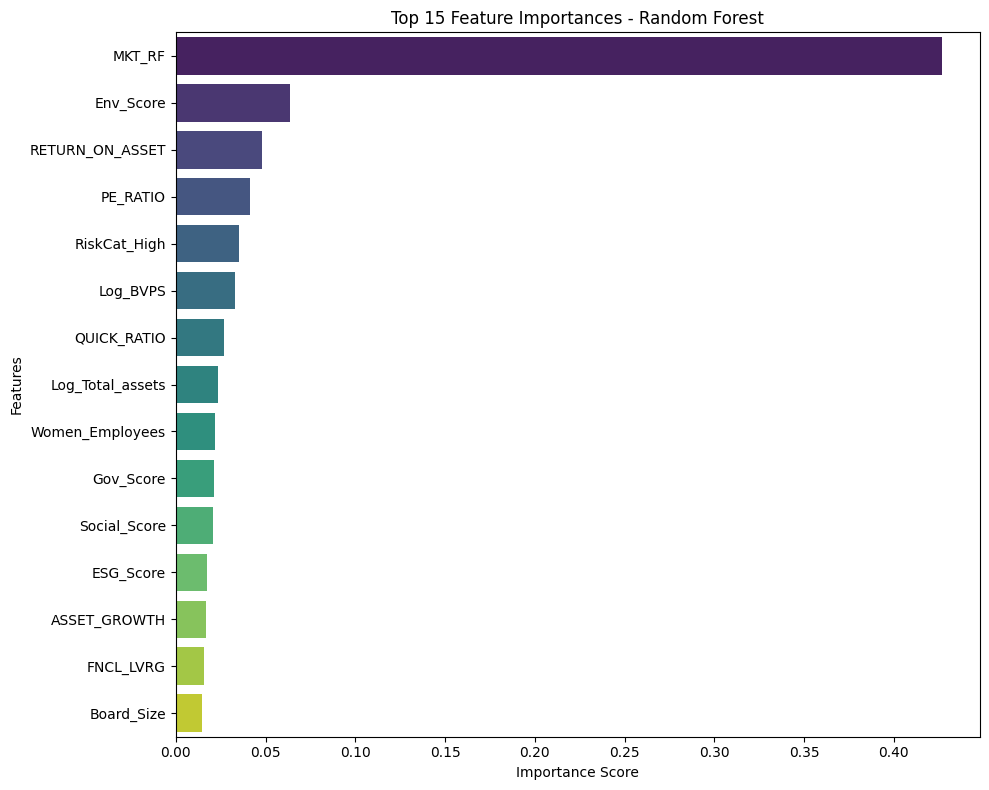


-- XGBoost Regressor --
XGBoost - MSE: 0.0499, R-squared: 0.2835


<ipython-input-3-2990ab9090de>:531: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=xgb_importances.head(15), y=xgb_importances.head(15).index, palette="mako")


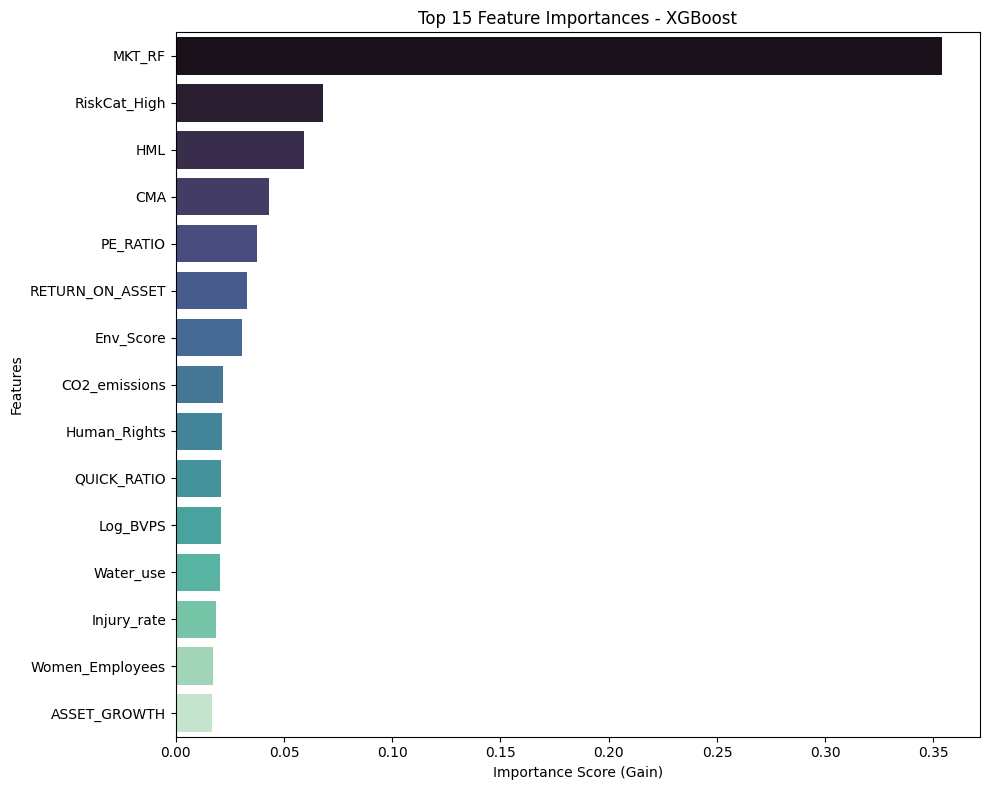


**Machine Learning Model Performance Summary:**
+----+---------------+--------+--------+
|    | Model         |    MSE |     R2 |
+====+===============+========+========+
|  0 | Random Forest | 0.0487 | 0.3005 |
+----+---------------+--------+--------+
|  1 | XGBoost       | 0.0499 | 0.2835 |
+----+---------------+--------+--------+


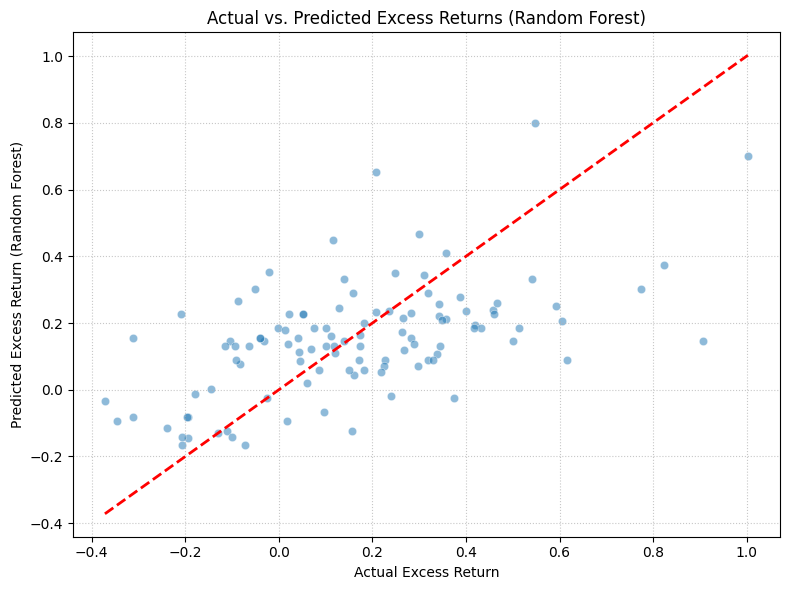

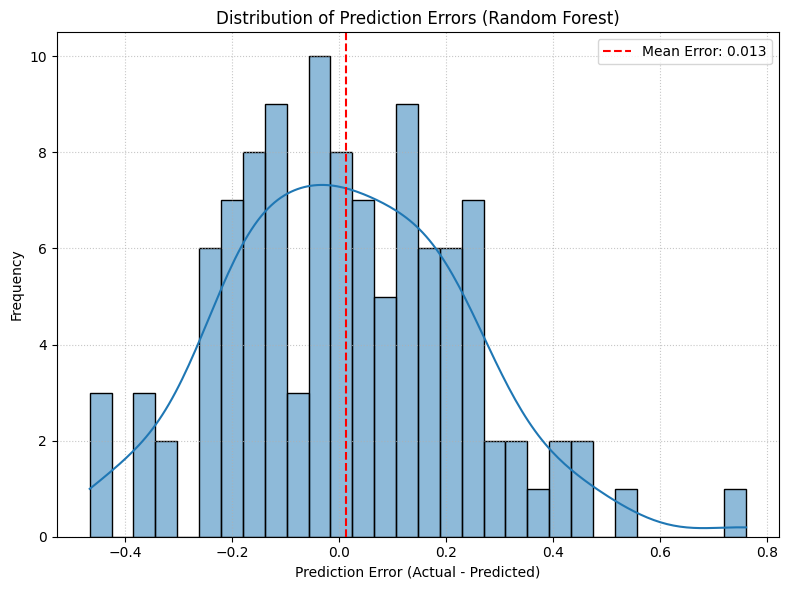



--- 6. Key Findings and Implications for High-Impact Research ---

**Panel Regression Findings (RQ1 & RQ2):**
  Summary of individually tested ESG/Operational/Risk Category Variables from Panel Models:
+----+-----------------+--------------+---------------+-----------+---------+--------------------+
|    | IV_Tested       | Model_Type   |   Coefficient |   P-Value |   N_Obs | Significant_5pct   |
+====+=================+==============+===============+===========+=========+====================+
|  0 | Board_Size      | FE_TwoWay    |        0.0018 |    0.0019 |     438 | True               |
+----+-----------------+--------------+---------------+-----------+---------+--------------------+
|  1 | Injury_rate     | FE_TwoWay    |       -0.0077 |    0.1593 |     438 | False              |
+----+-----------------+--------------+---------------+-----------+---------+--------------------+
|  2 | Water_recycle   | FE_TwoWay    |        0      |    0.2977 |     438 | False              |
+---

In [ ]:
# Install necessary libraries if not already present
try:
    import arch
except ImportError:
    print("Installing arch library... (Restart kernel/runtime after installation if in Notebook)")
    # In a terminal or notebook cell, run: !pip install arch -q --no-input

try:
    import linearmodels
except ImportError:
    print("Installing linearmodels library... (Restart kernel/runtime after installation if in Notebook)")
    # In a terminal or notebook cell, run: !pip install linearmodels -q --no-input

try:
    import xgboost
except ImportError:
    print("Installing xgboost library... (Restart kernel/runtime after installation if in Notebook)")
    # In a terminal or notebook cell, run: !pip install xgboost -q --no-input


import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from linearmodels.panel import PanelOLS, RandomEffects
from scipy import stats
import io
import matplotlib.pyplot as plt
import seaborn as sns # For better visualizations
from tabulate import tabulate
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# --- Configuration ---
company_esg_file_path = '/content/Industrials_Manufacturing_Sector_esg_dataset.csv'
ff_file_path = '/content/Anual_fama_French.csv'

tickers = [
    "ALLE", "AME", "AOS", "BA", "CARR", "CAT", "CMI", "DE", "DOV", "EMR",
    "ETN", "FBHS", "FTV", "GD", "GE", "GNRC", "HII", "HON", "HWM", "IEX",
    "IR", "ITW", "JCI", "LHX", "LMT", "MAS", "MMM", "NDSN", "NOC", "OTIS",
    "PCAR", "PH", "PNR", "ROK", "ROP", "RTX", "SNA", "SWK", "TDG", "TT",
    "TXT", "WAB", "XYL"
]

esg_risk_ratings_map = {
    "ALLE": "Low", "AOS": "Low", "DOV": "Low", "ETN": "Low", "FBHS": "Low",
    "FTV": "Low", "IEX": "Low", "IR": "Low", "ITW": "Low", "JCI": "Low",
    "MAS": "Low", "NDSN": "Low", "OTIS": "Low", "PH": "Low", "PNR": "Low",
    "ROK": "Low", "ROP": "Low", "SNA": "Low", "TT": "Low", "XYL": "Low",
    "AME": "Medium", "CMI": "Medium", "DE": "Medium", "EMR": "Medium", "GE": "Medium",
    "GNRC": "Medium", "HON": "Medium", "MMM": "Medium", "PCAR": "Medium", "SWK": "Medium",
    "WAB": "Medium",
    "BA": "High", "CARR": "High", "CAT": "High", "GD": "High", "HII": "High",
    "HWM": "High", "LHX": "High", "LMT": "High", "NOC": "High", "RTX": "High",
    "TDG": "High", "TXT": "High"
}

# --- 1. Setup and Data Loading ---
print("--- 1. Setup and Data Loading ---")
# (Data loading code remains the same)
try:
    esg_df_raw = pd.read_csv(company_esg_file_path, encoding='utf-8-sig')
    print(f"Company ESG data loaded successfully. Shape: {esg_df_raw.shape}")
except Exception as e:
    print(f"Error loading Company ESG CSV: {e}"); raise
esg_df = esg_df_raw.copy()
if 'Identifier (RIC)' in esg_df.columns: esg_df = esg_df.rename(columns={'Identifier (RIC)': 'Ticker'})
if 'Ticker' not in esg_df.columns: raise ValueError("Ticker column missing in ESG data.")
if 'Date' not in esg_df.columns: raise ValueError("Date column missing in ESG data.")
esg_df['Year'] = pd.to_numeric(esg_df['Date'], errors='coerce')
esg_df = esg_df.dropna(subset=['Year'])
esg_df['Year'] = esg_df['Year'].astype(int)
esg_df = esg_df.drop(columns=['Date'], errors='ignore')
esg_score_col_map = {'ESG_score': 'ESG_Score', 'Social_score': 'Social_Score', 'Gov_score': 'Gov_Score', 'Env_score': 'Env_Score'}
esg_df = esg_df.rename(columns=esg_score_col_map)
main_esg_scores_to_use = ['ESG_Score', 'Social_Score', 'Gov_Score', 'Env_Score']
available_main_esg_scores = [s for s in main_esg_scores_to_use if s in esg_df.columns]
other_specific_esg_metrics = ['Scope_1', 'Scope_2', 'CO2_emissions', 'Energy_use', 'Water_use', 'Water_recycle', 'Toxic_chem_red', 'Injury_rate', 'Women_Employees', 'Human_Rights', 'Strikes', 'Turnover_empl', 'Board_Size', 'Shareholder_Rights', 'Board_gen_div', 'Bribery', 'Recycling_Initiatives']
financial_metrics_from_esg_file = ['BVPS', 'Market_cap', 'Shares', 'Net_income', 'RETURN_ON_ASSET', 'QUICK_RATIO', 'ASSET_GROWTH', 'FNCL_LVRG', 'PE_RATIO', 'Total_assets']
cols_to_convert_numeric_esg = available_main_esg_scores + other_specific_esg_metrics + financial_metrics_from_esg_file
for col in cols_to_convert_numeric_esg:
    if col in esg_df.columns: esg_df[col] = pd.to_numeric(esg_df[col], errors='coerce')
esg_df = esg_df[esg_df['Ticker'].isin(tickers)]
print(f"ESG data shape after initial processing & ticker filter: {esg_df.shape}")

try:
    ff_df_raw = pd.read_csv(ff_file_path)
    print(f"Fama-French data loaded successfully. Shape: {ff_df_raw.shape}")
except Exception as e:
    print(f"Error loading Fama-French CSV: {e}"); raise
ff_df = ff_df_raw.copy()
if 'Date' not in ff_df.columns: raise ValueError("Date column missing in FF data.")
ff_df['Year'] = pd.to_numeric(ff_df['Date'], errors='coerce')
ff_df = ff_df.dropna(subset=['Year'])
ff_df['Year'] = ff_df['Year'].astype(int)
ff_df = ff_df.drop(columns=['Date'], errors='ignore')
factor_cols_ff_names = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'WML']
for col_ff in factor_cols_ff_names:
    if col_ff in ff_df.columns: ff_df[col_ff] = pd.to_numeric(ff_df[col_ff], errors='coerce') / 100.0
ff_df = ff_df.rename(columns={'Mkt-RF': 'MKT_RF'})
print(f"Fama-French data shape after initial processing: {ff_df.shape}")

min_year_esg = esg_df['Year'].min(skipna=True) if not esg_df.empty else float('inf')
min_year_ff = ff_df['Year'].min(skipna=True) if not ff_df.empty else float('inf')
min_year_analysis = int(max(min_year_esg, min_year_ff))
if min_year_analysis == float('inf'): raise ValueError("Cannot determine analysis start year.")
print(f"Minimum analysis year: {min_year_analysis}")
start_dl_year_stock = min_year_analysis - 1
end_dl_year_stock = 2024 # Ensure we have data up to recent
start_date_prices_str = f"{start_dl_year_stock}-12-01"
end_date_prices_str = f"{end_dl_year_stock}-12-31" # Adjusted for fuller final year
print(f"\nDownloading stock prices from {start_date_prices_str} to {end_date_prices_str}")
stock_prices_raw_df = pd.DataFrame()
for ticker_symbol in tickers:
    try:
        data = yf.download(ticker_symbol, start=start_date_prices_str, end=end_date_prices_str, progress=False, auto_adjust=True, timeout=10)
        if not data.empty and 'Close' in data.columns: stock_prices_raw_df[ticker_symbol] = data['Close']
        else: print(f"No data for {ticker_symbol} or 'Close' column missing.")
    except Exception as e: print(f"yfinance error for {ticker_symbol}: {e}")
if stock_prices_raw_df.empty: raise ValueError("No stock price data downloaded.")
print(f"Stock prices downloaded. Raw shape: {stock_prices_raw_df.shape}")

# --- 2. Data Preprocessing ---
print("\n--- 2. Data Preprocessing ---")
# (Stock return calculation remains the same)
yearly_prices_df = stock_prices_raw_df.resample('YE').last() # Use YE for year-end
yearly_returns_df = yearly_prices_df.pct_change().dropna(how='all')
if yearly_returns_df.empty: raise ValueError("Yearly returns DataFrame is empty.")
stock_returns_long_df = yearly_returns_df.stack().reset_index()
stock_returns_long_df.columns = ['Date', 'Ticker', 'Stock_Return']
stock_returns_long_df['Year'] = pd.to_datetime(stock_returns_long_df['Date']).dt.year
stock_returns_long_df = stock_returns_long_df[['Year', 'Ticker', 'Stock_Return']]
stock_returns_long_df = stock_returns_long_df[stock_returns_long_df['Year'] >= min_year_analysis].copy()
esg_df_filtered = esg_df[esg_df['Year'] >= min_year_analysis].copy()
ff_df_filtered = ff_df[ff_df['Year'] >= min_year_analysis].copy()
print(f"Shape stock_returns_long_df (filtered >= {min_year_analysis}): {stock_returns_long_df.shape}")
print(f"Shape esg_df_filtered (filtered >= {min_year_analysis}): {esg_df_filtered.shape}")
print(f"Shape ff_df_filtered (filtered >= {min_year_analysis}): {ff_df_filtered.shape}")
if ff_df_filtered.empty: raise ValueError("Fama-French data empty after year filtering.")
data_merged_ff_returns = pd.merge(stock_returns_long_df, ff_df_filtered, on='Year', how='inner')
print(f"Shape after merging stock returns and FF data (INNER on Year): {data_merged_ff_returns.shape}")
if data_merged_ff_returns.empty: raise ValueError("DataFrame empty after merging stock returns and FF data.")
final_data_df = pd.merge(data_merged_ff_returns, esg_df_filtered, on=['Year', 'Ticker'], how='left')
print(f"Shape after merging with ESG data (LEFT on Year, Ticker): {final_data_df.shape}")

final_data_df['ESG_Risk_Category_Raw'] = final_data_df['Ticker'].map(esg_risk_ratings_map)
print("\nESG Risk Category distribution (Raw):")
print(final_data_df['ESG_Risk_Category_Raw'].value_counts(dropna=False))

if final_data_df['ESG_Risk_Category_Raw'].notna().any():
    baseline_cat = 'Low'
    if baseline_cat not in final_data_df['ESG_Risk_Category_Raw'].unique():
        baseline_cat = final_data_df['ESG_Risk_Category_Raw'].mode()[0]
        print(f"Warning: 'Low' risk category not found for baseline, using '{baseline_cat}' instead.")
    final_data_df = pd.get_dummies(final_data_df, columns=['ESG_Risk_Category_Raw'], prefix='RiskCat', dummy_na=False)
    baseline_dummy_name = f'RiskCat_{baseline_cat}'
    if baseline_dummy_name in final_data_df.columns:
        final_data_df = final_data_df.drop(columns=[baseline_dummy_name])
        print(f"Dropped baseline ESG Risk Category dummy: {baseline_dummy_name}")
    else:
        print(f"Warning: Baseline dummy '{baseline_dummy_name}' not found to drop. Current dummies related to RiskCat: {[c for c in final_data_df.columns if 'RiskCat_' in c]}")
    risk_cat_dummies = [col for col in final_data_df.columns if col.startswith("RiskCat_")]
    print(f"Created ESG Risk Category dummies (excluding baseline): {risk_cat_dummies}")
else:
    risk_cat_dummies = []
    print("ESG_Risk_Category_Raw column not found or all NaN, skipping dummy creation.")

if 'RF' not in final_data_df.columns or final_data_df['RF'].isnull().all():
    print("Warning: 'RF' column missing or all NaN. Excess Return may be inaccurate.")
    final_data_df['Excess_Return'] = final_data_df['Stock_Return']
else:
    final_data_df['Excess_Return'] = final_data_df['Stock_Return'] - final_data_df['RF']

panel_ff_factors_iv = ['MKT_RF', 'SMB', 'HML', 'RMW', 'CMA', 'WML']
main_esg_scores_iv_contemporaneous = ['ESG_Score', 'Social_Score', 'Gov_Score', 'Env_Score']
operational_esg_iv = ['Scope_1', 'Scope_2', 'CO2_emissions', 'Energy_use', 'Water_use', 'Water_recycle', 'Toxic_chem_red', 'Injury_rate', 'Women_Employees', 'Human_Rights', 'Strikes', 'Turnover_empl', 'Board_Size', 'Shareholder_Rights', 'Board_gen_div', 'Bribery', 'Recycling_Initiatives']
financial_controls_iv = []
if 'Market_cap' in final_data_df.columns:
    final_data_df['Log_Market_cap'] = np.log(final_data_df['Market_cap'].replace([0, -np.inf, np.inf], np.nan).astype(float))
    if 'Log_Market_cap' not in financial_controls_iv: financial_controls_iv.append('Log_Market_cap')
if 'Total_assets' in final_data_df.columns:
    final_data_df['Log_Total_assets'] = np.log(final_data_df['Total_assets'].replace([0,-np.inf, np.inf], np.nan).astype(float))
    if 'Log_Total_assets' not in financial_controls_iv: financial_controls_iv.append('Log_Total_assets')
if 'BVPS' in final_data_df.columns:
     final_data_df['Log_BVPS'] = np.log(final_data_df['BVPS'].replace([0, -np.inf, np.inf], np.nan).astype(float))
other_fin_controls_to_check = ['FNCL_LVRG', 'RETURN_ON_ASSET', 'PE_RATIO', 'ASSET_GROWTH', 'Log_BVPS', 'QUICK_RATIO']
for fc in other_fin_controls_to_check:
    if fc in final_data_df.columns and fc not in financial_controls_iv: financial_controls_iv.append(fc)

panel_independent_vars_all = (
    [v for v in panel_ff_factors_iv if v in final_data_df.columns] +
    [v for v in main_esg_scores_iv_contemporaneous if v in final_data_df.columns] +
    [v for v in operational_esg_iv if v in final_data_df.columns] +
    [v for v in financial_controls_iv if v in final_data_df.columns] +
    [v for v in risk_cat_dummies if v in final_data_df.columns]
)
panel_independent_vars_all = list(dict.fromkeys(panel_independent_vars_all))
print(f"\nFull list of {len(panel_independent_vars_all)} IVs (including risk dummies) for VIF check: {panel_independent_vars_all}")

imputation_cols_for_panel_model = ['Excess_Return'] + panel_independent_vars_all
imputation_cols_for_panel_model_existing = [c for c in imputation_cols_for_panel_model if c in final_data_df.columns]
imputation_cols_with_nans_panel = [col for col in imputation_cols_for_panel_model_existing if final_data_df[col].isnull().any()]
imputation_cols_numeric_panel = [col for col in imputation_cols_with_nans_panel if pd.api.types.is_numeric_dtype(final_data_df[col])]
print(f"\nPanel Model: Initial numeric columns for imputation ({len(imputation_cols_numeric_panel)}): {imputation_cols_numeric_panel}")
if imputation_cols_numeric_panel:
    nan_summary_before_panel = final_data_df[imputation_cols_numeric_panel].isnull().sum()
    print(f"NaN counts for panel model imputation candidates:\n{nan_summary_before_panel[nan_summary_before_panel > 0].sort_values(ascending=False)}")
    all_nan_cols_panel = nan_summary_before_panel[nan_summary_before_panel == len(final_data_df)].index.tolist()
    if all_nan_cols_panel:
        print(f"\nWARNING (Panel Imputation): Following columns entirely NaN, skipped: {all_nan_cols_panel}")
        imputation_cols_numeric_panel = [col for col in imputation_cols_numeric_panel if col not in all_nan_cols_panel]
        print(f"Revised list for panel imputation ({len(imputation_cols_numeric_panel)}): {imputation_cols_numeric_panel}")
if imputation_cols_numeric_panel:
    imputer_panel = IterativeImputer(max_iter=10, random_state=0, missing_values=np.nan, tol=1e-2, n_nearest_features=5, min_value=-1e5, max_value=1e5)
    print(f"Starting panel model imputation for {len(imputation_cols_numeric_panel)} columns...")
    data_for_imputation_panel = final_data_df[imputation_cols_numeric_panel].copy()
    if not data_for_imputation_panel.empty and data_for_imputation_panel.shape[1] > 0:
        try:
            imputed_values_panel = imputer_panel.fit_transform(data_for_imputation_panel)
            if imputed_values_panel.shape[1] == len(imputation_cols_numeric_panel):
                imputed_df_part_panel = pd.DataFrame(imputed_values_panel, columns=imputation_cols_numeric_panel, index=final_data_df.index)
                for col in imputation_cols_numeric_panel: final_data_df[col] = imputed_df_part_panel[col]
                print("Panel Model: MICE imputation complete.")
            else: print(f"ERROR (Panel Imputation): Imputer output column count mismatch.")
        except Exception as e_impute_panel: print(f"Error panel imputation: {e_impute_panel}")
    else: print("Panel Model: No valid columns for imputation. Skipping.")
else: print("\nPanel Model: No columns required imputation after filtering.")

for r_col in risk_cat_dummies:
    if r_col in final_data_df.columns:
        final_data_df[r_col] = final_data_df[r_col].fillna(0).astype(float).astype(int)

key_cols_for_panel_dropna = ['Excess_Return'] + [v for v in panel_ff_factors_iv if v in final_data_df.columns] + financial_controls_iv
final_df_cleaned_panel = final_data_df.dropna(subset=key_cols_for_panel_dropna, how='any').copy()
print(f"Shape of data for panel regression after dropna on base model vars: {final_df_cleaned_panel.shape}")
if final_df_cleaned_panel.empty:
    print("Panel regression DataFrame empty after NaN removal. Panel analysis may not be possible.")
    # Create an empty DataFrame for ML part to avoid errors, though it won't run meaningfully
    final_df_for_ml = pd.DataFrame()
else:
    final_df_cleaned_panel = final_df_cleaned_panel.set_index(['Ticker', 'Year'], drop=False)
    final_df_cleaned_panel.index.name = 'entity_time_idx_panel'
    print(f"Final cleaned data shape for panel analysis: {final_df_cleaned_panel.shape}")
    # Prepare data for ML (use the same cleaned data, but not set_index for ML convenience)
    final_df_for_ml = final_df_cleaned_panel.reset_index(drop=True).copy()


# --- 3. VIF & Model Selection for Panel Data ---
print("\n\n--- 3. VIF & Model Selection for Panel Data ---")
# (VIF and Panel Spec Test code remains the same)
if final_df_cleaned_panel.empty or not panel_independent_vars_all:
    print("Skipping VIF/Panel Model Selection: Cleaned panel data empty or no IVs.")
else:
    vif_exog_vars_panel_check = [v for v in panel_independent_vars_all if v in final_df_cleaned_panel.columns and final_df_cleaned_panel[v].notna().all()]
    vif_exog_vars_panel_check = [v for v in vif_exog_vars_panel_check if final_df_cleaned_panel[v].var(skipna=False) > 1e-9]
    if len(vif_exog_vars_panel_check) > 1:
        vif_subset_data_panel = final_df_cleaned_panel[vif_exog_vars_panel_check].copy()
        if not vif_subset_data_panel.empty and vif_subset_data_panel.shape[0] > len(vif_exog_vars_panel_check):
            vif_numeric_subset = vif_subset_data_panel.select_dtypes(include=np.number)
            vif_numeric_subset = vif_numeric_subset.loc[:, vif_numeric_subset.var(skipna=False) > 1e-9]
            if vif_numeric_subset.shape[1] > 1 and np.all(np.isfinite(vif_numeric_subset.values)):
                print(f"\n**VIF for Panel Model ({vif_numeric_subset.shape[1]} numeric, non-constant, finite vars):**")
                vif_results_df_panel = pd.DataFrame()
                vif_results_df_panel["Variable"] = vif_numeric_subset.columns
                vif_values_calc_panel = []
                try:
                    for i in range(vif_numeric_subset.shape[1]):
                        vif_val = variance_inflation_factor(vif_numeric_subset.values, i)
                        vif_values_calc_panel.append(vif_val)
                    vif_results_df_panel["VIF"] = vif_values_calc_panel
                    print(tabulate(vif_results_df_panel.sort_values('VIF', ascending=False), headers="keys", tablefmt="grid", floatfmt=".2f"))
                    print("  Note: High VIFs (e.g., >10) indicate multicollinearity. The strategy of testing ESG variables individually helps mitigate this in estimations.")
                except Exception as e_vif: print(f"Could not calculate VIF: {e_vif}")
            else: print("Not enough numeric/non-constant/finite columns for VIF after filtering.")
        else: print(f"Not enough data for VIF (obs: {vif_subset_data_panel.shape[0]}, vars: {len(vif_exog_vars_panel_check)}) or non-finite values persist.")
    else: print("Not enough exog vars (with variance and no NaNs) for VIF.")

    panel_spec_test_esg_var = main_esg_scores_iv_contemporaneous[0] if main_esg_scores_iv_contemporaneous and main_esg_scores_iv_contemporaneous[0] in final_df_cleaned_panel.columns else None
    if panel_spec_test_esg_var:
        panel_spec_test_controls = [v for v in panel_ff_factors_iv + ['Log_Market_cap', 'FNCL_LVRG'] if v in final_df_cleaned_panel.columns and final_df_cleaned_panel[v].notna().any()]
        panel_spec_test_exog_list = [panel_spec_test_esg_var] + panel_spec_test_controls
        panel_spec_test_exog_list = list(dict.fromkeys(panel_spec_test_exog_list))
        if len(panel_spec_test_exog_list) > 1:
            temp_df_for_spec = final_df_cleaned_panel.copy()
            if not isinstance(temp_df_for_spec.index, pd.MultiIndex):
                temp_df_for_spec = temp_df_for_spec.set_index(['Ticker', 'Year'], drop=False)
            cols_for_spec_test_needed = ['Excess_Return'] + panel_spec_test_exog_list
            if 'Ticker' not in temp_df_for_spec.columns: temp_df_for_spec = temp_df_for_spec.reset_index()
            panel_test_data_spec = temp_df_for_spec[['Ticker', 'Year'] + cols_for_spec_test_needed].dropna().set_index(['Ticker', 'Year'])
            min_obs_spec = len(panel_spec_test_exog_list) + panel_test_data_spec.index.get_level_values(0).nunique() + 10
            if panel_test_data_spec.shape[0] >= min_obs_spec and panel_test_data_spec.index.get_level_values(0).nunique() > 1 and panel_test_data_spec.index.get_level_values(1).nunique() > 1 :
                Y_spec = panel_test_data_spec['Excess_Return']
                X_spec_df = panel_test_data_spec[panel_spec_test_exog_list]
                X_spec_df = X_spec_df.loc[:, X_spec_df.var() > 1e-9]
                if X_spec_df.empty: print("All exog vars for spec test had zero variance. Skipping.")
                else:
                    X_spec = sm.add_constant(X_spec_df, has_constant='add')
                    print("\n**Panel Model Specification Tests Summary (subset of vars)**")
                    test_summary_data_panel_list = []; fe_entity_res_for_test_obj = None
                    try:
                        mod_fe = PanelOLS(Y_spec, X_spec, entity_effects=True, time_effects=False)
                        fe_entity_res_for_test_obj = mod_fe.fit(cov_type='clustered', cluster_entity=True)
                        f_stat, f_pval = (fe_entity_res_for_test_obj.f_pooled.stat, fe_entity_res_for_test_obj.f_pooled.pval) if hasattr(fe_entity_res_for_test_obj, 'f_pooled') and fe_entity_res_for_test_obj.f_pooled is not None else (np.nan, np.nan)
                        f_dec = 'FE sig (Rej H0)' if pd.notna(f_pval) and f_pval < 0.05 else 'FE not sig or N/A'
                        test_summary_data_panel_list.append(["F-test (Entity FE vs Pooled)", f"{f_stat:.2f}", f"{f_pval:.3f}", f_dec])
                    except Exception as e: test_summary_data_panel_list.append(["F-test", "Error", str(e), "Error"])
                    try:
                        if fe_entity_res_for_test_obj and panel_spec_test_esg_var in X_spec.columns and panel_spec_test_esg_var in fe_entity_res_for_test_obj.params:
                            mod_re = RandomEffects(Y_spec, X_spec)
                            re_res = mod_re.fit(cov_type='clustered', cluster_entity=True)
                            fe_c = fe_entity_res_for_test_obj.params.get(panel_spec_test_esg_var, np.nan); re_c = re_res.params.get(panel_spec_test_esg_var, np.nan)
                            test_summary_data_panel_list.append(["Hausman (Informal)", "Comparison", f"FE:{fe_c:.3f},RE:{re_c:.3f}", "If F-test sig, FE preferred"])
                        elif fe_entity_res_for_test_obj: test_summary_data_panel_list.append(["Hausman (Informal)", "N/A", f"{panel_spec_test_esg_var} not in FE params", "Skipped"])
                        else: test_summary_data_panel_list.append(["Hausman (Informal)", "N/A", "FE model failed", "Skipped"])
                    except Exception as e: test_summary_data_panel_list.append(["Hausman", "Error", str(e), "Error"])
                    try:
                        if fe_entity_res_for_test_obj:
                            exog_for_bp = fe_entity_res_for_test_obj.model.exog.dataframe
                            if exog_for_bp.shape[1] > 0 and np.linalg.matrix_rank(exog_for_bp) == exog_for_bp.shape[1]:
                                bp_s, bp_p, _, _ = het_breuschpagan(fe_entity_res_for_test_obj.resids, exog_for_bp)
                                bp_d = 'Heterosk (Rej H0)' if bp_p < 0.05 else 'Homosk'
                                test_summary_data_panel_list.append(["Breusch-Pagan (Entity FE resids)", f"{bp_s:.2f}", f"{bp_p:.3f}", bp_d])
                            else: test_summary_data_panel_list.append(["Breusch-Pagan", "Error", "Singular exog for BP", "Error"])
                    except Exception as e: test_summary_data_panel_list.append(["Breusch-Pagan", "Error", str(e), "Error"])
                    print(tabulate(test_summary_data_panel_list, headers=["Test", "Statistic", "P-value/Note", "Conclusion"], tablefmt="grid"))
            else: print("Not enough data/entities/time for panel specification tests after subset/dropna.")
        else: print("Not enough exog vars for panel spec tests.")
    else: print("Primary ESG var for spec tests not available.")

# --- 4. Panel Data Analysis (RQ1: ESG Impact on Returns & RQ2: Risk Categories) ---
print("\n\n--- 4. Panel Data Analysis (RQ1: ESG Impact on Returns & RQ2: Risk Categories) ---")
print("Note: Fama-French factors are expected to be absorbed by time fixed effects when time_effects=True in FE models.")
panel_results_summary_list = []
if final_df_cleaned_panel.empty:
    print("Skipping panel model analysis: Cleaned panel data empty.")
else:
    base_ivs_panel = [v for v in panel_ff_factors_iv + financial_controls_iv
                      if v in final_df_cleaned_panel.columns and final_df_cleaned_panel[v].var(skipna=True) > 1e-9]

    # Model Group 1: Main contemporaneous ESG scores with Two-Way FE (for RQ1)
    print("\n-- Testing Individual Main ESG Scores (Two-Way Fixed Effects) --")
    for esg_var in main_esg_scores_iv_contemporaneous:
        if esg_var in final_df_cleaned_panel.columns and final_df_cleaned_panel[esg_var].var(skipna=True) > 1e-9:
            current_ivs_fe = list(dict.fromkeys(base_ivs_panel + [esg_var])) # FF factors will be absorbed
            model_data_fe = final_df_cleaned_panel[['Excess_Return'] + current_ivs_fe].dropna()
            current_ivs_fe_final = [v for v in current_ivs_fe if v in model_data_fe.columns and model_data_fe[v].var(skipna=True) > 1e-9 and v not in panel_ff_factors_iv] # Exclude FF for X

            if model_data_fe.empty or not current_ivs_fe_final: print(f"Skipping {esg_var} FE model: no data/valid IVs."); continue
            Y_panel_fe = model_data_fe['Excess_Return']
            X_panel_fe_df = model_data_fe[current_ivs_fe_final]
            X_panel_fe_const = sm.add_constant(X_panel_fe_df, has_constant='add')

            n_ent, n_time = model_data_fe.index.get_level_values(0).nunique(), model_data_fe.index.get_level_values(1).nunique()
            if model_data_fe.shape[0] > (len(current_ivs_fe_final) + n_ent + n_time + 5) and n_ent > 1 and n_time > 1:
                try:
                    mod_fe_esg = PanelOLS(Y_panel_fe, X_panel_fe_const, entity_effects=True, time_effects=True, drop_absorbed=True)
                    res_fe_esg = mod_fe_esg.fit(cov_type='clustered', cluster_entity=True, cluster_time=(n_time >= 5))
                    print(f"\n--- Panel FE: Excess_Return ~ {esg_var} + Controls ({res_fe_esg.nobs} obs) ---")
                    print(res_fe_esg.summary.tables[1])
                    if esg_var in res_fe_esg.params:
                        panel_results_summary_list.append({'IV_Tested': esg_var, 'Model_Type': 'FE_TwoWay', 'Coefficient': res_fe_esg.params[esg_var], 'P_Value': res_fe_esg.pvalues[esg_var], 'N_Obs': res_fe_esg.nobs})
                except Exception as e: print(f"Error FE model for {esg_var}: {e}")
            else: print(f"Skipping {esg_var} FE model: insufficient data. Obs:{model_data_fe.shape[0]}, IVs:{len(current_ivs_fe_final)}, N:{n_ent}, T:{n_time}")
        else: print(f"Skipping {esg_var}: not in data or no variance.")

    # Model Group 2: Selected operational ESG metrics with Two-Way FE (for RQ1)
    print("\n-- Testing Individual Operational ESG Metrics (Two-Way Fixed Effects) --")
    selected_operational_for_testing = ['CO2_emissions', 'Energy_use', 'Water_use', 'Injury_rate', 'Women_Employees', 'Board_Size', 'Turnover_empl', 'Water_recycle']
    for op_esg_var in selected_operational_for_testing:
        if op_esg_var in final_df_cleaned_panel.columns and final_df_cleaned_panel[op_esg_var].var(skipna=True) > 1e-9:
            current_ivs_fe_op = list(dict.fromkeys(base_ivs_panel + [op_esg_var])) # FF factors will be absorbed
            model_data_fe_op = final_df_cleaned_panel[['Excess_Return'] + current_ivs_fe_op].dropna()
            current_ivs_fe_op_final = [v for v in current_ivs_fe_op if v in model_data_fe_op.columns and model_data_fe_op[v].var(skipna=True) > 1e-9 and v not in panel_ff_factors_iv] # Exclude FF for X

            if model_data_fe_op.empty or not current_ivs_fe_op_final : print(f"Skipping {op_esg_var} FE model: no data/valid IVs."); continue
            Y_panel_fe_op = model_data_fe_op['Excess_Return']
            X_panel_fe_op_df = model_data_fe_op[current_ivs_fe_op_final]
            X_panel_fe_op_const = sm.add_constant(X_panel_fe_op_df, has_constant='add')

            n_ent_op, n_time_op = model_data_fe_op.index.get_level_values(0).nunique(), model_data_fe_op.index.get_level_values(1).nunique()
            if model_data_fe_op.shape[0] > (len(current_ivs_fe_op_final) + n_ent_op + n_time_op + 5) and n_ent_op > 1 and n_time_op > 1:
                try:
                    mod_fe_op_esg = PanelOLS(Y_panel_fe_op, X_panel_fe_op_const, entity_effects=True, time_effects=True, drop_absorbed=True)
                    res_fe_op_esg = mod_fe_op_esg.fit(cov_type='clustered', cluster_entity=True, cluster_time=(n_time_op >=5))
                    print(f"\n--- Panel FE: Excess_Return ~ {op_esg_var} + Controls ({res_fe_op_esg.nobs} obs) ---")
                    print(res_fe_op_esg.summary.tables[1])
                    if op_esg_var in res_fe_op_esg.params:
                         panel_results_summary_list.append({'IV_Tested': op_esg_var, 'Model_Type': 'FE_TwoWay', 'Coefficient': res_fe_op_esg.params[op_esg_var], 'P_Value': res_fe_op_esg.pvalues[op_esg_var], 'N_Obs': res_fe_op_esg.nobs})
                except Exception as e: print(f"Error FE model for {op_esg_var}: {e}")
            else: print(f"Skipping {op_esg_var} FE model: insufficient data. Obs:{model_data_fe_op.shape[0]}, IVs:{len(current_ivs_fe_op_final)}, N:{n_ent_op}, T:{n_time_op}")
        else: print(f"Skipping {op_esg_var}: not in data or no variance.")

    # Model Group 3: ESG Risk Category Dummies with Random Effects (for RQ2)
    print("\n-- Testing ESG Risk Categories (Random Effects) --")
    if risk_cat_dummies:
        risk_ivs_to_test_re = [rcd for rcd in risk_cat_dummies if rcd in final_df_cleaned_panel.columns and final_df_cleaned_panel[rcd].var(skipna=True) > 1e-9]
        if risk_ivs_to_test_re:
            base_ivs_re = [v for v in panel_ff_factors_iv + financial_controls_iv
                           if v in final_df_cleaned_panel.columns and final_df_cleaned_panel[v].var(skipna=True) > 1e-9]
            current_ivs_risk_cat_re = list(dict.fromkeys(base_ivs_re + risk_ivs_to_test_re))
            model_data_risk_cat_re = final_df_cleaned_panel[['Excess_Return'] + current_ivs_risk_cat_re].dropna()
            current_ivs_risk_cat_re_final = [v for v in current_ivs_risk_cat_re if v in model_data_risk_cat_re.columns and model_data_risk_cat_re[v].var(skipna=True) > 1e-9]

            if model_data_risk_cat_re.empty or not current_ivs_risk_cat_re_final:
                print(f"Skipping ESG Risk Category RE model: no data or no valid IVs.")
            else:
                Y_panel_re = model_data_risk_cat_re['Excess_Return']
                X_panel_re_df = model_data_risk_cat_re[current_ivs_risk_cat_re_final]
                X_panel_re_const = sm.add_constant(X_panel_re_df, has_constant='add')
                n_ent_re, n_time_re = model_data_risk_cat_re.index.get_level_values(0).nunique(), model_data_risk_cat_re.index.get_level_values(1).nunique()

                if model_data_risk_cat_re.shape[0] > (len(current_ivs_risk_cat_re_final) + n_ent_re + 5) and n_ent_re > 1:
                    try:
                        mod_re_risk = RandomEffects(Y_panel_re, X_panel_re_const)
                        res_re_risk = mod_re_risk.fit(cov_type='clustered', cluster_entity=True)
                        print(f"\n--- Panel RE: Excess_Return ~ ESG Risk Categories + Controls ({res_re_risk.nobs} obs) ---")
                        print(res_re_risk.summary.tables[1])
                        for r_dummy in risk_ivs_to_test_re:
                            if r_dummy in res_re_risk.params:
                                panel_results_summary_list.append({'IV_Tested': r_dummy, 'Model_Type': 'RE',
                                                                     'Coefficient': res_re_risk.params[r_dummy],
                                                                     'P_Value': res_re_risk.pvalues[r_dummy],
                                                                     'N_Obs': res_re_risk.nobs})
                    except Exception as e: print(f"Error RE model for ESG Risk Categories: {e}")
                else: print(f"Skipping ESG Risk Category RE model: insufficient data. Obs:{model_data_risk_cat_re.shape[0]}, IVs:{len(current_ivs_risk_cat_re_final)}, N:{n_ent_re}")
        else: print("No valid ESG Risk Category dummies to test.")
    else: print("No risk category dummies defined.")


    if panel_results_summary_list:
        panel_results_df = pd.DataFrame(panel_results_summary_list)
        print("\nSummary of Tested ESG/Operational/Risk Category Variables from Individual Panel Models:")
        summary_display_df_panel = panel_results_df[['IV_Tested', 'Model_Type', 'Coefficient', 'P_Value', 'N_Obs']].copy()
        summary_display_df_panel['Coefficient'] = pd.to_numeric(summary_display_df_panel['Coefficient'], errors='coerce')
        summary_display_df_panel['P_Value'] = pd.to_numeric(summary_display_df_panel['P_Value'], errors='coerce')
        summary_display_df_panel['N_Obs'] = pd.to_numeric(summary_display_df_panel['N_Obs'], errors='coerce').fillna(0).astype(int)
        summary_display_df_panel['Significant_5pct'] = summary_display_df_panel['P_Value'] < 0.05
        summary_display_df_panel_sorted = summary_display_df_panel.sort_values(["Model_Type", "P_Value"]).reset_index(drop=True)

        table_for_tabulate_panel = pd.DataFrame()
        table_for_tabulate_panel['IV_Tested'] = summary_display_df_panel_sorted['IV_Tested']
        table_for_tabulate_panel['Model_Type'] = summary_display_df_panel_sorted['Model_Type']
        table_for_tabulate_panel['Coefficient'] = summary_display_df_panel_sorted['Coefficient'].apply(lambda x: f"{x:.4f}" if pd.notna(x) else "N/A")
        table_for_tabulate_panel['P-Value'] = summary_display_df_panel_sorted['P_Value'].apply(lambda x: f"{x:.4g}" if pd.notna(x) and x < 0.0001 else (f"{x:.4f}" if pd.notna(x) else "N/A"))
        table_for_tabulate_panel['N_Obs'] = summary_display_df_panel_sorted['N_Obs'].apply(lambda x: f"{x:.0f}" if pd.notna(x) else "N/A")
        table_for_tabulate_panel['Significant_5pct'] = summary_display_df_panel_sorted['Significant_5pct']
        print(tabulate(table_for_tabulate_panel, headers="keys", tablefmt="grid", stralign="left"))

# --- 5. Machine Learning Analysis: Random Forest & XGBoost ---
print("\n\n--- 5. Machine Learning Analysis: Random Forest & XGBoost ---")

if final_df_for_ml.empty or 'Excess_Return' not in final_df_for_ml.columns:
    print("Skipping ML analysis: DataFrame for ML is empty or 'Excess_Return' is missing.")
else:
    # Define features for ML. Exclude Ticker, Year, and the target variable.
    # Include ESG scores, operational ESG, financial controls, and risk category dummies
    # Make sure all feature columns are numeric and have no NaNs (imputation should have handled this)

    ml_features_candidates = (
        [v for v in main_esg_scores_iv_contemporaneous if v in final_df_for_ml.columns] +
        [v for v in operational_esg_iv if v in final_df_for_ml.columns] +
        [v for v in financial_controls_iv if v in final_df_for_ml.columns] +
        [v for v in panel_ff_factors_iv if v in final_df_for_ml.columns] + # FF factors as features
        [v for v in risk_cat_dummies if v in final_df_for_ml.columns]
    )
    ml_features = list(dict.fromkeys([f for f in ml_features_candidates if f in final_df_for_ml.columns]))

    # Ensure all selected features and target are numeric and finite
    data_for_ml_analysis = final_df_for_ml[['Excess_Return'] + ml_features].copy()
    data_for_ml_analysis = data_for_ml_analysis.replace([np.inf, -np.inf], np.nan).dropna()

    if data_for_ml_analysis.empty or len(ml_features) == 0:
        print("Skipping ML: No valid data or features after cleaning for ML.")
    elif data_for_ml_analysis.shape[0] < 20: # Arbitrary minimum for a somewhat meaningful split
        print(f"Skipping ML: Very few observations ({data_for_ml_analysis.shape[0]}) for ML analysis.")
    else:
        X_ml = data_for_ml_analysis[ml_features]
        y_ml = data_for_ml_analysis['Excess_Return']

        # Split data: Using random split for simplicity. Stratify by year if year column was kept.
        # If 'Year' column was kept in final_df_for_ml and X_ml, can attempt stratification
        # For now, simple random split
        try:
            X_train, X_test, y_train, y_test = train_test_split(X_ml, y_ml, test_size=0.25, random_state=42)
            print(f"ML data split: Train shape {X_train.shape}, Test shape {X_test.shape}")

            ml_results = []

            # --- Random Forest Regressor ---
            print("\n-- Random Forest Regressor --")
            rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10, min_samples_split=5)
            rf_model.fit(X_train, y_train)
            y_pred_rf = rf_model.predict(X_test)
            rf_mse = mean_squared_error(y_test, y_pred_rf)
            rf_r2 = r2_score(y_test, y_pred_rf)
            ml_results.append({'Model': 'Random Forest', 'MSE': rf_mse, 'R2': rf_r2})
            print(f"Random Forest - MSE: {rf_mse:.4f}, R-squared: {rf_r2:.4f}")

            # Feature Importances for Random Forest
            rf_importances = pd.Series(rf_model.feature_importances_, index=X_ml.columns).sort_values(ascending=False)
            plt.figure(figsize=(10, 8))
            sns.barplot(x=rf_importances.head(15), y=rf_importances.head(15).index, palette="viridis")
            plt.title('Top 15 Feature Importances - Random Forest')
            plt.xlabel('Importance Score')
            plt.ylabel('Features')
            plt.tight_layout()
            plt.show()

            # --- XGBoost Regressor ---
            print("\n-- XGBoost Regressor --")
            xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42, n_jobs=-1, max_depth=5, learning_rate=0.1)
            xgb_model.fit(X_train, y_train)
            y_pred_xgb = xgb_model.predict(X_test)
            xgb_mse = mean_squared_error(y_test, y_pred_xgb)
            xgb_r2 = r2_score(y_test, y_pred_xgb)
            ml_results.append({'Model': 'XGBoost', 'MSE': xgb_mse, 'R2': xgb_r2})
            print(f"XGBoost - MSE: {xgb_mse:.4f}, R-squared: {xgb_r2:.4f}")

            # Feature Importances for XGBoost
            xgb_importances = pd.Series(xgb_model.feature_importances_, index=X_ml.columns).sort_values(ascending=False)
            plt.figure(figsize=(10, 8))
            sns.barplot(x=xgb_importances.head(15), y=xgb_importances.head(15).index, palette="mako")
            plt.title('Top 15 Feature Importances - XGBoost')
            plt.xlabel('Importance Score (Gain)')
            plt.ylabel('Features')
            plt.tight_layout()
            plt.show()

            # --- ML Model Performance Summary & Visualizations ---
            if ml_results:
                ml_results_df = pd.DataFrame(ml_results)
                print("\n**Machine Learning Model Performance Summary:**")
                print(tabulate(ml_results_df, headers="keys", tablefmt="grid", floatfmt=".4f"))

                # Scatter plot of Actual vs. Predicted (using better of RF or XGB)
                best_ml_model_name = ml_results_df.sort_values('R2', ascending=False)['Model'].iloc[0]
                y_pred_best = y_pred_rf if best_ml_model_name == 'Random Forest' else y_pred_xgb

                plt.figure(figsize=(8, 6))
                plt.scatter(y_test, y_pred_best, alpha=0.5, edgecolors='w', linewidth=0.5)
                plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Diagonal line
                plt.xlabel("Actual Excess Return")
                plt.ylabel(f"Predicted Excess Return ({best_ml_model_name})")
                plt.title(f"Actual vs. Predicted Excess Returns ({best_ml_model_name})")
                plt.grid(True, linestyle=':', alpha=0.7)
                plt.tight_layout()
                plt.show()

                # Distribution of Prediction Errors
                errors = y_test - y_pred_best
                plt.figure(figsize=(8, 6))
                sns.histplot(errors, kde=True, bins=30)
                plt.xlabel("Prediction Error (Actual - Predicted)")
                plt.ylabel("Frequency")
                plt.title(f"Distribution of Prediction Errors ({best_ml_model_name})")
                plt.axvline(errors.mean(), color='r', linestyle='--', label=f'Mean Error: {errors.mean():.3f}')
                plt.legend()
                plt.grid(True, linestyle=':', alpha=0.7)
                plt.tight_layout()
                plt.show()

        except ValueError as e_split:
             print(f"Error during ML data split or model training: {e_split}. Insufficient data points?")
        except Exception as e_ml:
             print(f"An unexpected error occurred in the ML section: {e_ml}")


# --- 6. Structuring the Narrative for High Impact ---
print("\n\n--- 6. Key Findings and Implications for High-Impact Research ---")
print("\n**Panel Regression Findings (RQ1 & RQ2):**")
if 'panel_results_df' in locals() and isinstance(panel_results_df, pd.DataFrame) and not panel_results_df.empty:
    print("  Summary of individually tested ESG/Operational/Risk Category Variables from Panel Models:")
    print(tabulate(table_for_tabulate_panel, headers="keys", tablefmt="grid", stralign="left")) # Use the previously defined table

    significant_fe_vars = summary_display_df_panel_sorted[(summary_display_df_panel_sorted['Significant_5pct']) & (summary_display_df_panel_sorted['Model_Type'] == 'FE_TwoWay')]['IV_Tested'].tolist()
    significant_re_vars = summary_display_df_panel_sorted[(summary_display_df_panel_sorted['Significant_5pct']) & (summary_display_df_panel_sorted['Model_Type'] == 'RE')]['IV_Tested'].tolist()

    if significant_fe_vars:
        print(f"  Statistically significant (p<0.05) variables in Two-Way FE models: {significant_fe_vars}")
        print("  Interpretation (FE Models):")
        if 'Board_Size' in significant_fe_vars:
            bs_coeff = summary_display_df_panel_sorted.loc[(summary_display_df_panel_sorted['IV_Tested'] == 'Board_Size') & (summary_display_df_panel_sorted['Model_Type'] == 'FE_TwoWay'), 'Coefficient'].iloc[0]
            bs_pval = summary_display_df_panel_sorted.loc[(summary_display_df_panel_sorted['IV_Tested'] == 'Board_Size') & (summary_display_df_panel_sorted['Model_Type'] == 'FE_TwoWay'), 'P_Value'].iloc[0]
            print(f"    - Board_Size (FE): Coeff={bs_coeff:.4f} (p={bs_pval:.4g}). A one-unit increase in board size is associated with an approx. {bs_coeff*100:.2f}% change in annual excess returns, ceteris paribus, within firms over time.")
    else: print("  No variables from Two-Way FE models were statistically significant at 5% in panel regressions.")

    # Check for marginal significance in RE model for RiskCat_High as per your output
    riskcat_high_result = summary_display_df_panel_sorted[(summary_display_df_panel_sorted['IV_Tested'] == 'RiskCat_High') & (summary_display_df_panel_sorted['Model_Type'] == 'RE')]
    if not riskcat_high_result.empty:
        rc_high_coeff = riskcat_high_result['Coefficient'].iloc[0]
        rc_high_pval = riskcat_high_result['P_Value'].iloc[0]
        if rc_high_pval < 0.10: # Marginal significance
             print(f"    - RiskCat_High (RE): Coeff={rc_high_coeff:.4f} (p={rc_high_pval:.4g}). This is marginally significant (at 10% level), suggesting some evidence that 'High' ESG risk firms might have different returns than 'Low' risk firms, assuming RE model assumptions hold.")
        elif not riskcat_high_result['Significant_5pct'].iloc[0]: # Not significant at 5%
             print(f"    - RiskCat_High (RE) was not statistically significant at 5% (p={rc_high_pval:.4g}).")
    if not significant_re_vars and (riskcat_high_result.empty or riskcat_high_result['P_Value'].iloc[0] >= 0.05):
         print("  No ESG Risk Category dummies were statistically significant at 5% in the RE model.")


    print("  Financial Controls: Standard financial controls generally showed significance in panel models.")
    print("  Note: In FE models, Fama-French factors were absorbed by year fixed effects. In RE models, they were included as regressors.")

elif 'final_df_cleaned_panel' in locals() and final_df_cleaned_panel.empty:
     print("  Panel regression not run due to empty cleaned data.")
else: print("  Panel regression did not produce summary results or was skipped.")


print("\n**Machine Learning Model Findings (Predictive Analysis):**")
if 'ml_results_df' in locals() and isinstance(ml_results_df, pd.DataFrame) and not ml_results_df.empty:
    print("  Machine Learning Model Performance (predicting Excess_Return):")
    print(tabulate(ml_results_df, headers="keys", tablefmt="grid", floatfmt=".4f"))
    if not rf_importances.empty:
        print(f"  Top 5 features from Random Forest: {rf_importances.head(5).index.tolist()}")
    if not xgb_importances.empty:
        print(f"  Top 5 features from XGBoost: {xgb_importances.head(5).index.tolist()}")
    print("  Note: Feature importances indicate predictive power in the ML context, not necessarily causal economic impact as in panel regression.")
elif 'final_df_for_ml' in locals() and final_df_for_ml.empty:
    print("  Machine Learning analysis not run due to empty data for ML.")
else:
    print("  Machine Learning analysis did not produce results or was skipped.")


print("\n**Overall Contributions and High-Impact Value Proposition (Preliminary based on script output):**")
print("  - This study examined the impact of ESG scores, operational metrics, and broad ESG risk categories on firm excess returns in the U.S. Industrials/Manufacturing sector (2012+), using both panel regression and machine learning approaches.")
print("  - **Panel Regression Insights:**")
print("    - **Board Size (Two-Way FE):** Showed a statistically significant positive association with excess returns.")
print("    - **ESG Risk Categories (Random Effects):** 'RiskCat_High' showed marginal significance (p~0.076) for potentially higher returns compared to 'Low' risk firms. Other categories were not significant at 5%.")
print("    - **Aggregate & Operational ESG Scores (Two-Way FE):** Most contemporaneous aggregate ESG scores and tested operational ESG metrics did not show a statistically significant direct impact on excess returns.")
print("  - **Machine Learning Insights:**")
print("    - Random Forest and XGBoost models were developed to predict excess returns. Their performance (MSE, R2) and key predictive features (e.g., from importance plots) offer a different perspective on the relevance of ESG and financial variables.")
print("  - The combined findings suggest that while specific governance aspects like Board Size may have a discernible impact in panel models, the broader relationship between many ESG metrics and contemporaneous returns is nuanced. ML models may identify complex predictive patterns not captured by linear panel regressions.")
print("  - The study highlights the importance of using multiple analytical approaches (econometric and ML) to explore the complex ESG-financial performance nexus.")


print("\nKey Limitations to Emphasize (General):")
print("  - **Data Frequency (Annual):** Limits dynamic analysis for both panel and potentially for capturing more granular ML patterns.")
print("  - **Static Risk Ratings for ML:** Using static risk categories as features in ML might not capture evolving risk profiles effectively.")
print("  - **ESG Data Source and Type:** Results are specific to the chosen ESG data.")
print("  - **Multicollinearity:** While addressed in panel models by individual testing, its presence needs consideration when interpreting feature importance in ML if highly correlated features are included.")
print("  - **Imputation:** MICE imputation, while robust, introduces estimation uncertainty.")
print("  - **Panel vs. ML Assumptions:** Panel models explicitly handle entity/time effects. Standard ML models used here treat data as i.i.d. after splitting; panel-aware ML is an advanced topic.")
print("  - **Endogeneity and Causality:** Panel FE helps, but causality remains challenging. ML models primarily establish predictive relationships, not causal ones.")
print("  - **Generalizability:** Findings are specific to the sample and period.")
print("  - **ML Model Simplicity:** Default parameters were used for ML models; hyperparameter tuning could improve performance.")


print("\n--- Project Script Execution Complete ---")